# INFO284 - Gruppeeksamen

Candidatenumber: 199,106,252,243



# 1.0: Preprosessering


## 1.1: Importerer nødvendige biblioteker
Vi starter med å åpne csv-filen som inneholder datasettet vi skal arbeide videre med, og å importere nødvendige moduler til senere bruk. Filen inneholder en rekke data om fisketurer og fangst, og er inndelt i kolonner og rader.

Filen skiller de ulike elementene i en rad med ";", mens standard separator er ",". På samme måte brukes det i filen "," for å angi desimaler, mens standard er "." Vi må derfor angi hvordan maskinen skal lese filen ved å angi ny separator og desimaltegn, slik at maskinen leser dataene på korrekt måte.

In [475]:
import pandas as pd
import numpy as np
from sklearn import linear_model  # For den lineære modellen.
from sklearn.model_selection import train_test_split  # For å splitte datasettet.
import datetime as dt
import matplotlib.pyplot as plt  # For statistikk og grafiske fremstillinger.
import seaborn as sns  # For statistikk og grafiske fremstillinger
from sklearn.preprocessing import MinMaxScaler, StandardScaler # For skalering

from sklearn.metrics import mean_squared_error # For å måle resultat

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
# For MLPregressor
from sklearn.datasets import make_regression
from sklearn.neural_network import MLPRegressor




from sklearn.cluster import KMeans #Til clustering modellen


df = pd.read_csv("elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv", sep=';', decimal=',')

## 1.2: Splitte datasett
Vi splitter datasettet vårt inn i train og test data tidlig. Dette er fordi at modellene kan «huske» settet som den bygges opp av (train settet), og vil dermed alltid yte godt på dette settet. Vi får imidlertid ikke muligheten til å se hvor godt modellene fungerer på ny data. For å kunne vurdere modellenes ytelse, må vi altså vise modellene ny data når de skal testes, altså data som modellen ikke tidligere har sett (Müller & Guido, 2017).

Ved å splitte datasettet vårt tidlig sørger vi altså for at modellene ikke allerede har "sett" test dataene slik at vi risikerer uriktige resultater når vi skal vurdere hvor gode modellene vi har bygd opp er.


In [476]:
# Splitter datasettet i train_df og test_df
train_df, test_df = train_test_split(df, test_size = 0.15, random_state = 1)

## 1.3: Utforske datasettet:
Før man skal bygge maskinlæringsmodeller, bør man aller først utforske datasettet man skal jobbe med (Müller & Guido, 2017). Vi starter derfor med å undersøke hva datasettet inneholder av informasjon, og hvordan dataen er organisert.

In [477]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 259618 entries, 197039 to 128037
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Melding ID                259618 non-null  int64  
 1   Meldingstidspunkt         259618 non-null  object 
 2   Meldingsdato              259618 non-null  object 
 3   Meldingsklokkeslett       259618 non-null  object 
 4   Starttidspunkt            259618 non-null  object 
 5   Startdato                 259618 non-null  object 
 6   Startklokkeslett          259618 non-null  object 
 7   Startposisjon bredde      259618 non-null  float64
 8   Startposisjon lengde      259618 non-null  float64
 9   Hovedområde start (kode)  257896 non-null  float64
 10  Hovedområde start         256066 non-null  object 
 11  Lokasjon start (kode)     257896 non-null  float64
 12  Havdybde start            259618 non-null  int64  
 13  Stopptidspunkt            259618 non-null  o

Av df.info ser vi tittel på de ulike kolonnene og hvilken datatype de inneholder. I tillegg ser vi hvor mange "non-null" verdier som eksisterer. Her ser vi at det eksisterer null-verdier i de fleste kolonner. Dette indikerer at de kan  finnes overflødige felter som kan renses bort på et senere tidspunkt.

**Organisering av datasettet**

Datasettet er videre organisert slik at hver rad inneholder informasjon om fangst av en art, herunder blant annet informasjon om tidspunkt, lokasjon, båtstørrelse, mengde fisk og fiskeart. Vi bemerker oss særlig to ting; informasjon om samme fiskeaktivitet er registrert over flere rader, og det eksisterer to kolonner for bruttotonnasje.

***Fiskeaktivitet:***

Vi ser at flere rader kan inneholde informasjon om samme fisketur, hvor blant annet start og sluttidspunkt er den samme. De ulike fangstene som er gjort på samme tidspunkt med samme meldingID ser altså ut til å være knyttet til samme fiskeaktivitet.

***Bruttotonnasje:***

Vi ser videre at det finnes to ulike kolonner for Bruttotonnasje. "Bruttotonn er totalvolumet av alle lukkede rom som er i bruk på et skip." (Osnes, 2024). Bruttotonnasje sier altså noe om det totale volumet av hulrom i båten. Selv om det ikke kan sammenlignes med lastekapasitet, kan det være en indikator på dette. Vi ser her at Bruttotonnasje er delt inn i to ulike kolonner («Bruttotonnasje 1969» og «Bruttotonnasje annen»). Verdien per båt er videre fordelt på en av de to kolonnene, men aldri begge samtidig.


**Videre undersøkelser**

Vi ønsker som utgangspunkt å se om det er mulig å predikere rundvekt av en bestemt art med den informasjonen vi har. Siden fiskere bruker ulike redskaper for å fange fisk, kan vi anta at noen redskaper og metoder er mer egnet for å fange bestemte arter. Vi vet også at det foregår fiske etter ulike arter på ulike steder og tidspunkt. Kunnskap om hvordan, hvor og hva som fiskes etter er derfor viktig for å forstå datasettet. Videre vil vi undersøke denne type informasjonen.

In [478]:
# Først undersøker vi hvor mange registreringer det er av de ulike fisketypene og hvor mye det fiskes av hver.

species_weight_sum = train_df.groupby('Art - gruppe')['Rundvekt'].sum().sort_values(ascending=False)
print(train_df['Art - gruppe'].value_counts())
print(species_weight_sum)

Art - gruppe
Torsk                                       48216
Annen torskefisk                            38397
Sei                                         36195
Hyse                                        33370
Annen flatfisk, bunnfisk og dypvannsfisk    21363
Uer                                         16713
Steinbiter                                  13786
Dypvannsreke                                11625
Blåkveite                                    6784
Snøkrabbe                                    5172
Sild, annen                                  5108
Skater og annen bruskfisk                    3480
Makrell                                      2519
Kolmule                                      2403
Øyepål                                       1887
Annen pelagisk fisk                          1526
Vassild og strømsild                         1411
Andre skalldyr, bløtdyr og pigghuder         1133
Lodde                                        1013
Tobis og annen sil                   

Observerer en hovedvekt av fiske etter torsk og sei.

Vi ser videre på hvilke redskaper som brukes hyppigst, og hvor hvor mye total rundvekt de ulike redskapene er registrert med.

In [479]:
# Gjør samme undersøkelse av redskaper.

redskap_weight_sum = train_df.groupby('Redskap FDIR')['Rundvekt'].sum().sort_values(ascending=False)
print(train_df['Redskap FDIR'].value_counts())
print(redskap_weight_sum)

Redskap FDIR
Bunntrål                                  102470
Snurrevad                                  43868
Andre liner                                37409
Reketrål                                   19071
Udefinert garn                             16387
Udefinert trål                             13386
Snurpenot/ringnot                          10791
Teiner                                      5820
Bunntrål par                                2843
Dobbeltrål                                  2392
Flytetrål                                   2331
Flytetrål par                               1301
Settegarn                                    534
Harpun og lignende uspesifiserte typer       413
Annet                                        410
Juksa/pilk                                    18
Dorg/harp/snik                                14
Name: count, dtype: int64
Redskap FDIR
Snurpenot/ringnot                         660284018.0
Flytetrål                                 402390349.0
Bunntrå

Brunntrål og Snurrevad viser seg å være de mest brukte fangstredskapene, etterfulgt av andre liner og reketrål.

Vi vet fra fiskeridirektoratet at bunntrål og snurrevad er fiskeredskaper som samler fisk ved å slepe eller trekke garn/not gjennom vannet. "Andre liner" er fiskeredskaper med agn og krok som kan settes ut (Fiskeridirektoratet, 2022).

Vi har nå fått en oversikt over hvilke fisker som fiskes, og hvilke redskaper som brukes. Videre er det naturlig å undersøke hvordan sammensetningen av fisk er med de ulike fangstmetodene, og hvor vanlig metodene er.

Vi har valgt å fokusere spesielt på bunntrål og snurrevad, ettersom vi har mye data på disse redskapene, og de har noe lik fangstmetodikk.

In [480]:
# Ser etter hvilke fisk som blir fisket med Bunntrål:
condition = train_df[train_df['Redskap FDIR'] == 'Bunntrål']
species_weight_sum = condition.groupby('Art - gruppe')['Rundvekt'].sum().sort_values(ascending=False)
print(condition['Art - gruppe'].value_counts(), species_weight_sum)

Art - gruppe
Torsk                                       19870
Sei                                         15538
Hyse                                        14150
Annen torskefisk                            12723
Uer                                         12112
Annen flatfisk, bunnfisk og dypvannsfisk     7327
Dypvannsreke                                 6320
Steinbiter                                   6228
Blåkveite                                    4296
Skater og annen bruskfisk                     676
Øyepål                                        618
Andre skalldyr, bløtdyr og pigghuder          523
Vassild og strømsild                          425
Kolmule                                       410
Annen pelagisk fisk                           335
Sild, annen                                   272
Makrell                                       196
Tobis og annen sil                            144
Haifisk                                        53
Lodde                                

In [481]:
# Ser etter hvilke fisk som blir fisket med Snurrevad:
condition = train_df[train_df['Redskap FDIR'] == 'Snurrevad']

species_weight_sum = condition.groupby('Art - gruppe')['Rundvekt'].sum().sort_values(ascending=False)
print(condition['Art - gruppe'].value_counts(), species_weight_sum)

Art - gruppe
Torsk                                       13947
Hyse                                        10189
Sei                                          9589
Annen flatfisk, bunnfisk og dypvannsfisk     3525
Annen torskefisk                             3465
Steinbiter                                   1096
Uer                                           680
Blåkveite                                     312
Sild, annen                                    25
Makrell                                        20
Skater og annen bruskfisk                      10
Lodde                                           9
Dypvannsreke                                    8
Andre skalldyr, bløtdyr og pigghuder            4
Haifisk                                         3
Annen pelagisk fisk                             1
Name: count, dtype: int64 Art - gruppe
Torsk                                       49029858.0
Sei                                         20003749.0
Hyse                                  

Etter å ha studert de ulike redskapene og hva som blir fisket med dem, observeres også konturene av hvordan de blir brukt. Bunntrål fanger blandt annet mest torsk og sei, men også mye av andre arter. Dette er det redskapet som vi har undersøkt som har jevnest fordeling av arter, som betyr at det er det redskapet som bidrar med mest bifangst. Snurrevad gir også mye torsk og sei, men virker å være et noe mer målrettet fiskeredskap, ettersom spredningen av fangst av forskjellige arter ikke er like stor.

Basert på denne informasjonen er det interessant å dykke videre inn i et bestemt redskap og art, og se på muligheten for å begrense oss til et bestemt havområde.

Vi danner oss derfor en oversikt over de ulike fiskeområdene og ser på fordelingen registreringer som er gjort per område.


In [482]:
print(train_df['Hovedområde start'].value_counts())

Hovedområde start
Eigersundbanken                  38458
Røstbanken til Malangsgrunnen    24805
Vest-Finnmark                    23567
Øst-Finnmark                     22987
Bjørnøya                         21473
Shetland                         21015
Nordkappbanken                   15818
Vikingbanken                     14145
Skagerrak                        13713
Storegga-Frøyabanken             12636
Helgelandsbanken                  7282
Sentralbanken                     4734
Storbanken                        4062
Thor Iversens Bank                3875
Vestfjorden (Lofoten)             3800
Sentrale Nordsjø                  2866
Hopen                             2686
Sørlige Norskehav                 1709
Vest av Skottland (Hebridene)     1691
Østlige Norskehav                 1653
Admiralityfeltet                  1609
Skolpenbanken                     1604
Gåsebanken                        1467
Storfjord/Hinlopenstredet         1174
Vest-Spitsbergen                  1069
Vest av

### 1.3.1 Konklusjon av første titt på data:
Med utgangspunkt i dataen, ønsker vi å filtrere ut data etter følgende betingelser: Hovedart - Sei, Område - Norskekysten, fangstredskap - Trål.

Vi har valgt å fokusere på seifiske, siden dette er en av de fiskene som blir fisket hyppigst i Norge i følge dataen.

Når det gjelder lokasjon, er det hovedsaklig fiske etter to grupper av sei. En gruppe som beiter i havområdene mellom Norge og Skottland (Havforskningsinstituttet, 2019), og en annen som beiter i kystområdene fra vestlandet til finnmark (Havforskningsinstituttet 2019).

Dersom vi ønsker å fokusere på den nordøstarktiske seien, kan basert på informasjonen være lurt å fokusere på hovedområdene med kode fra 0,1, 3-7 og 28. Om vi skal inkludere Nordsjøseien, så kan  områdene 40-43 inkluderes, men da beveger vi oss litt utenfor de de norske områdene.

Siden det eksisterer et så stort omfang av trålfiske, så eksisterer det også mye data. Trål er også det redskapet som er mest brukt for å fiske sei.

For å finne oversikt over de aktuelle hovedområdene, benyttes karttjenesten til fiskeridirektoratet (Fiskeridirektoratet, 2018).

## 1.4: Filtrere data
Spesifiserer for train-settet at vi vil se på sei-fiske, nordøstlige områder og bunntrål, og filtrerer bort alle rader som ikke inneholder disse verdiene. Gjør og det samme for test-settet.

Tar utgangspunkt i alle radene hvor sei er angitt som Hovedart, som innebærer at bifangst på turer hvor sei er registrert som hovedart også blir inkludert. Det betyr dog at rader hvor sei er registrert som bifangst blir kuttet.

Videre ser vi en beskrivelse av dataene som er registrert på seifiske, og en oversikt over normalfordeling av dataene.

In [483]:
# Lager en betingelse med aktuelle områder.
northeastern = [0, 1, 3, 4, 5, 6, 7, 28]
northeastern_ocean = [30, 34, 37, 39, 12, 36] # For å undersøke om det er noe særlig seifiske utenfor de mer kystnære strøk
northsea = [40, 41, 42, 43] # For å undersøke seifiske
# Legger inn betingelser i train_df.
filtered_train_df = train_df[
    (train_df['Hovedart FAO'] == 'Sei') &
    (train_df['Hovedområde start (kode)'].isin(northeastern)) &
    (train_df['Redskap FDIR'] == 'Bunntrål')
]

# Gjør det samme med test-settet
filtered_test_df = test_df[
    (test_df['Hovedart FAO'] == 'Sei') &
    (test_df['Hovedområde start (kode)'].isin(northeastern)) &
    (test_df['Redskap FDIR'] == 'Bunntrål')
]

filtered_train_df.describe()  # Får her et inntrykk av ekstremverdier og gjennomsnitt.

Melding ID  Startposisjon bredde  Startposisjon lengde  \
count  2.305200e+04          23052.000000          23052.000000   
mean   1.646902e+06             66.726729             13.024531   
std    9.421848e+04              4.131016              8.349201   
min    1.497341e+06             60.001000              2.005000   
25%    1.549459e+06             62.834000              5.327000   
50%    1.666098e+06             68.089000             10.919000   
75%    1.729002e+06             70.868000             20.594000   
max    1.800286e+06             71.998000             32.279000   

       Hovedområde start (kode)  Lokasjon start (kode)  Havdybde start  \
count              23052.000000           23052.000000    23052.000000   
mean                   8.615131              19.144369     -189.178726   
std                    8.320031              13.896382       64.695234   
min                    0.000000               1.000000     -761.000000   
25%                    4.000000               9.000000     -226.000000   
50%                    5.000000              15.000000     -183.000000   
75%                    7.000000              23.000000     -146.000000   
max                   28.000000              54.000000        1.000000   

           Varighet  Fangstår  Stopposisjon bredde  Stopposisjon lengde  ...  \
count  23052.000000   23052.0         23052.000000         23052.000000  ...   
mean     255.544335    2018.0            66.743387            13.059604  ...   
std       89.438977       0.0             4.141896             8.366921  ...   
min        6.000000    2018.0            59.647000             1.654000  ...   
25%      195.000000    2018.0            62.839000             5.342000  ...   
50%      267.000000    2018.0            68.106000            11.021000  ...   
75%      321.000000    2018.0            70.884000            20.601000  ...   
max     1706.000000    2018.0            72.060000            32.226000  ...   

       Redskap FDIR (kode)  Hovedart - FDIR (kode)  Art - FDIR (kode)  \
count              23052.0                 23052.0       23052.000000   
mean                  51.0                  1032.0        1238.381659   
std                    0.0                     0.0         454.527792   
min                   51.0                  1032.0         529.000000   
25%                   51.0                  1032.0        1023.000000   
50%                   51.0                  1032.0        1032.000000   
75%                   51.0                  1032.0        1034.000000   
max                   51.0                  1032.0        2919.000000   

       Art - gruppe (kode)      Rundvekt  Lengdegruppe (kode)  \
count         23052.000000  23052.000000         23052.000000   
mean            225.204191   2664.065157             4.935754   
std              39.915937   5353.717212             0.283285   
min             201.000000      0.000000             3.000000   
25%             202.000000     78.000000             5.000000   
50%             203.000000    263.000000             5.000000   
75%             220.000000   2333.250000             5.000000   
max             520.000000  86506.000000             5.000000   

       Bruttotonnasje 1969  Bruttotonnasje annen        Bredde  Fartøylengde  
count         22368.000000            684.000000  23052.000000  23052.000000  
mean           1953.940451            166.245614     12.918734     57.233963  
std            1077.025399             15.872605      2.262440     15.124058  
min             197.000000            129.000000      7.000000     19.750000  
25%            1199.000000            173.000000     12.200000     50.800000  
50%            1598.000000            173.000000     13.000000     56.800000  
75%            2610.000000            173.000000     15.000000     69.900000  
max            4427.000000            173.000000     16.700000     81.200000  

[8 rows x 24 columns]

## 1.5: Gruppere data og fjerne kolonner:
Vi gruppere data ved å slå sammen rader som gjelder samme fiskeaktivitet. Det kan argumenteres for at det ville vært gunstig å gjort tidligere, dog kunne man ha oversett nyanser i datasettet.

Ved å observere dataen først lærte vi at for hver fiskeaktivitet så er det registrert flere arter og rundvekt av hver art, selv om hovedarten er den samme. Dersom man ikke har et bilde av hvordan fordelingen av rundvekt er, så kan man senere få utfordringer med modellene. Derfor er vi bevisste på at det å slå disse registreringene av rundvekt sammen, beregnes også rundvekten for hele fangsten, ikke bare rundvekten av hovedarten.

F.eks. ved å predikere fangst basert på redskapet trål, gitt omfanget av oppgaven, er det naturlig å regne rundvekt basert på hele fangsten, dog med fokus på en bestemt art.

Vi har gjort en antakelse om at total rundvekt kan gi oss en pekepinn på hva en god fangst er, uavhengig av hvilke arter som er fanget. Kanskje er målrettet fiske i realiteten mer lønnsomt, men når man fisker med trål så er mangfoldet av arter som fanges en del av bildet og gir en større total rundvekt.

In [484]:
# Funksjon for å samle de sammenslåtte dataene som tekststreng.
def join_unique_values(series):
    return ', '.join(series.dropna().astype(str).unique())

grouped_df = filtered_train_df.groupby(['Melding ID', 'Meldingstidspunkt'], as_index=False).agg({
    'Melding ID': 'first', # Trengs muligens for å skille aktiviterer fra ulike båter.
    'Meldingstidspunkt': 'first',
    'Meldingsdato': 'first',
    'Meldingsklokkeslett': 'first',
    'Starttidspunkt': 'first',
    'Startdato': 'first',
    'Startklokkeslett': 'first',
    'Startposisjon bredde': 'first',
    'Startposisjon lengde': 'first',
    'Hovedområde start (kode)': 'first',
    #'Hovedområde start': 'first',  # Vi forholder oss til koden, da blir denne kolonnen irrelevant
    #'Lokasjon start (kode)': 'first', # Mye tomme celler, dokumentasjonen advarer om å bruke denne kolonnen.
    'Havdybde start': 'first',
    'Stopptidspunkt': 'first',
    'Stoppdato': 'first',
    'Stoppklokkeslett': 'first',
    'Varighet': 'first',
    #'Fangstår': 'first', Så og si alle fangstdata er registrert i 2018.
    'Stopposisjon bredde': 'first',
    'Stopposisjon lengde': 'first',
    # 'Hovedområde stopp (kode)': 'first', # Vi forholder oss til området hvor fisket starter.
    #'Hovedområde stopp': 'first',
    #'Lokasjon stopp (kode)': 'first', # Unødvendig å ha med videre.
    'Havdybde stopp': 'first',
    'Trekkavstand': 'first',
    #'Redskap FAO (kode)': 'first', # Unødvendig med flere kolonner av redskaper
    #'Redskap FAO': 'first',
    #'Redskap FDIR (kode)': 'first',
    'Redskap FDIR': 'first', # Vi forholder oss FDIR sine kolonner av redskaper.
    #'Hovedart FAO (kode)': 'first',
    'Hovedart FAO': 'first',
    #'Hovedart - FDIR (kode)': 'first',
    #'Art FAO (kode)': join_unique_values, # Sletter bifangst radene, siden vi ikke er interessert i å se på bifangst.
    #'Art FAO': join_unique_values,
    #'Art - FDIR (kode)': join_unique_values,
    #'Art - FDIR': join_unique_values,
    #'Art - gruppe (kode)':
    #'Art - gruppe': 'Join_unique_values'
    'Rundvekt': 'sum', # Summerer sammen fangsten på en aktivitet.
    'Lengdegruppe (kode)': 'first',
    'Lengdegruppe': 'first',
    'Bruttotonnasje 1969': 'first',
    'Bruttotonnasje annen': 'first',
    'Bredde': 'first',
    'Fartøylengde': 'first'
    })

grouped_df.head()

Melding ID Meldingstidspunkt Meldingsdato Meldingsklokkeslett  \
0     1497341  01.01.2018 23:30   01.01.2018               23:30   
1     1497435  02.01.2018 07:50   02.01.2018               07:50   
2     1497823  02.01.2018 23:31   02.01.2018               23:31   
3     1497827  02.01.2018 23:31   02.01.2018               23:31   
4     1497843  02.01.2018 23:45   02.01.2018               23:45   

     Starttidspunkt   Startdato Startklokkeslett  Startposisjon bredde  \
0  01.01.2018 18:54  01.01.2018            18:54                61.283   
1  01.01.2018 03:21  01.01.2018            03:21                68.256   
2  02.01.2018 00:20  02.01.2018            00:20                68.535   
3  02.01.2018 18:02  02.01.2018            18:02                69.450   
4  02.01.2018 16:52  02.01.2018            16:52                63.122   

   Startposisjon lengde  Hovedområde start (kode)  ...  Trekkavstand  \
0                 2.074                      28.0  ...       16590.0   
1                10.828                       5.0  ...       43775.0   
2                11.986                       5.0  ...       35125.0   
3                15.783                       5.0  ...        6814.0   
4                 5.381                       7.0  ...       34192.0   

  Redskap FDIR Hovedart FAO Rundvekt  Lengdegruppe (kode)  Lengdegruppe  \
0     Bunntrål          Sei   3000.0                  5.0  28 m og over   
1     Bunntrål          Sei  32379.0                  5.0  28 m og over   
2     Bunntrål          Sei  16837.0                  5.0  28 m og over   
3     Bunntrål          Sei   3770.0                  4.0    21-27,99 m   
4     Bunntrål          Sei   1685.0                  5.0  28 m og over   

   Bruttotonnasje 1969  Bruttotonnasje annen  Bredde Fartøylengde  
0               2053.0                   NaN   13.00        75.50  
1               2580.0                   NaN   14.60        64.00  
2               2580.0                   NaN   14.60        64.00  
3                  NaN                 129.0    7.01        25.07  
4                536.0                   NaN   10.30        33.95  

[5 rows x 28 columns]

## 1.6: Utforske datasettet på nytt
Etter en grov filtering og gjennomgang av datasettet ønsker vi å spisse arbeidet videre mot en bestemt art, redskap og lokasjon. Derfor filteres det videre for å luke ut overføldig og gjentakense data.
I følge Müller & Guido (2017) er den beste måten å utforske datasettet på å visualisere dataene. Vi vil i tillegg forsøke å gruppere noen av dataene for å redusere dimensjonene av datasettet.

### 1.6.1 Rundvekt

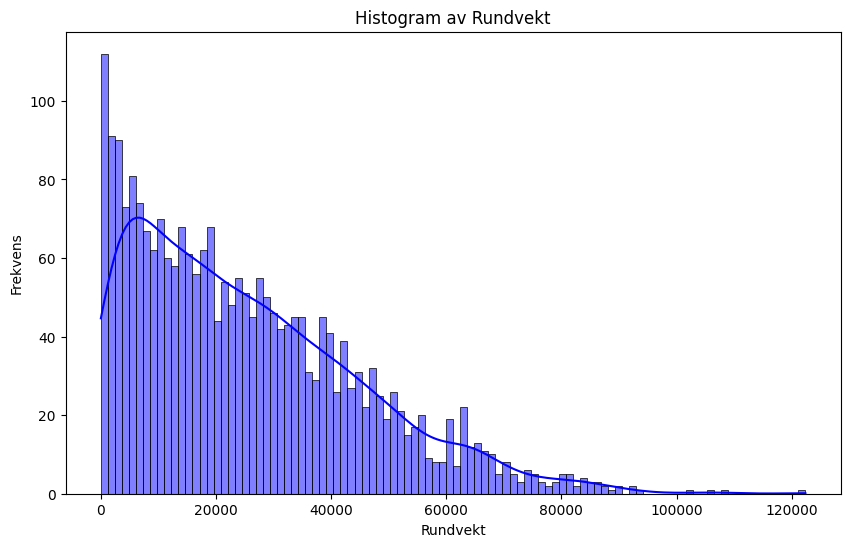

In [485]:
import seaborn as sns

# Ser på fordelingen av rundvekt.
plt.figure(figsize=(10, 6))
sns.histplot(grouped_df['Rundvekt'], kde=True, bins=100, color='blue')
plt.title('Histogram av Rundvekt')
plt.xlabel('Rundvekt')
plt.ylabel('Frekvens')
plt.show()

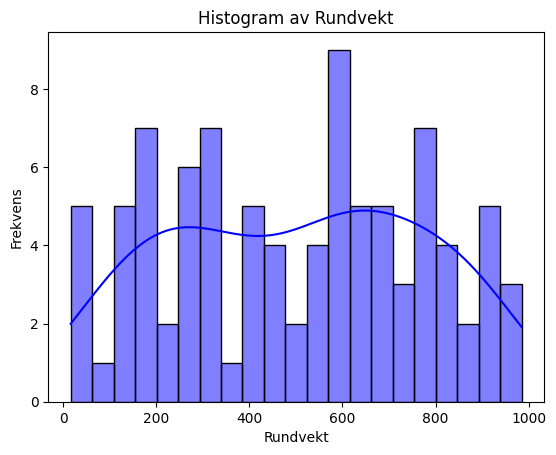

In [486]:
rundvekt = grouped_df[grouped_df['Rundvekt']< 1000]
sns.histplot(rundvekt['Rundvekt'], kde=True, bins=21, color='blue')
plt.title('Histogram av Rundvekt')
plt.xlabel('Rundvekt')
plt.ylabel('Frekvens')
plt.show()

Observerer at det eksisterer en del "bomturer" hvor fiskeaktiviteten ikke har gitt fangst. Dette vil vi komme tilbake til når vi skal rense data i punkt 7.

In [487]:
log_rundvekt = np.log(filtered_train_df['Rundvekt'])
log_rundvekt.skew()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


nan

### 1.6.2 Bruttotonnasje:
Det er vanskelig å vite hvilke mål på skipet som er de beste for å anslå skipets lastekapasitet, men vi har landet på bruttotonnasje som det beste målet.

For å bruke bruttotonnasje-kolonnene er vi nødt til å kombinere kolonnene "bruttotonnasje 1969" og "bruttotonnasje annen". I vedlegg til oppgaven står det følgende om bruttotonnasje 1969: "I denne variabelen, «Bruttotonnasje 1969», er det i dag ført bruttotonnasje for fartøy med lengde (L) større eller lik 24 meter (L), målt og berekna i medhald av internasjonal konvensjon om måling av fartøy, 1969 (London-konvensjonen 1969)."

Altså skip under 24m er ført i bruttotonnasje annen og de resterende i 1969. Siden ingen rader har verdier i begge kolonnene kan vi enkelt så de sammen.

In [488]:
# Slår sammen bruttotonnasje-gruppene.
grouped_df.loc[:, 'Bruttotonnasje kombinert'] = grouped_df['Bruttotonnasje 1969'].fillna(grouped_df['Bruttotonnasje annen'])

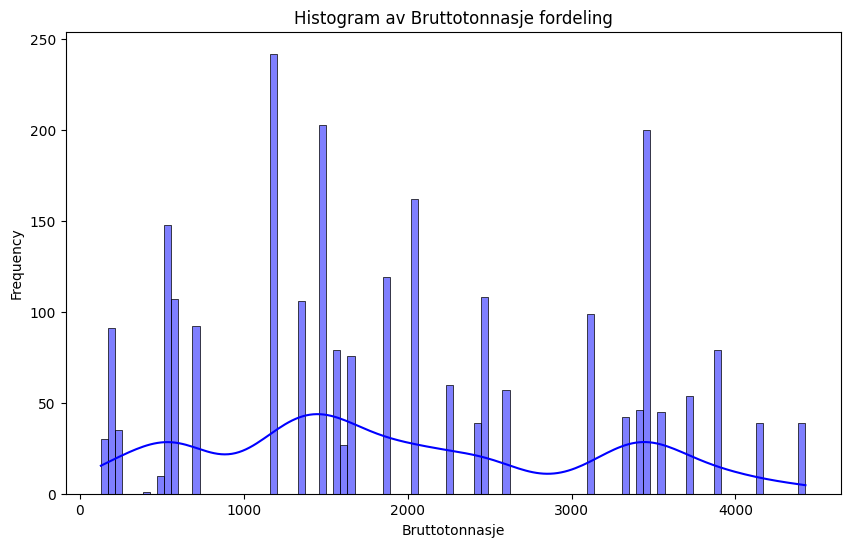

In [489]:
# Lager grafisk fremstilling av fordeling av båtstørrelse
plt.figure(figsize=(10, 6))
sns.histplot(grouped_df['Bruttotonnasje kombinert'], kde=True, bins=100, color='blue')
plt.title('Histogram av Bruttotonnasje fordeling')
plt.xlabel('Bruttotonnasje')
plt.ylabel('Frequency')
plt.show()

Ser tendenser av at båtstørrelsen deles grovt inn i tre kategorier: "Småbåter" under 1000 bruttotonn, "mellomstore" fra 1000 til 3000 og "store" over 3000. vi velger å gruppere båtene inn i disse tre gruppene.

In [490]:
# Grupperer Bruttotonnasje-kolonnen
bins = [0, 1000, 2000, 3000, 4000]
labels = [1, 2, 3, 4]
grouped_df['Bruttotonnasje gruppert'] = pd.cut(grouped_df['Bruttotonnasje kombinert'], bins=bins, labels=labels)

grouped_df['Bruttotonnasje gruppert'].value_counts()

Bruttotonnasje gruppert
2    852
4    565
1    514
3    426
Name: count, dtype: int64

### 1.6.3 Tidspunkt
Se hvordan aktiviteten er fordelt på måneder og timer.
Etter å ha testet de ulike kolonnene basert på fordeling av tid, observeres mange registreringer på startklokkeslett 00.00.



In [491]:
# Grupperer startklokkeslett i grupper etter timer slik at.
grouped_df['Startklokkeslett'] = pd.to_datetime(grouped_df['Startklokkeslett'], format='%H:%M')
grouped_df['Hours'] = grouped_df['Startklokkeslett'].dt.hour
print(grouped_df['Hours'].value_counts())

# Grupperer meldingsdato etter måneder.
grouped_df['Meldingsdato'] = pd.to_datetime(grouped_df['Meldingsdato'], format='%d.%m.%Y', errors='coerce')
grouped_df['Month'] = grouped_df['Meldingsdato'].dt.month
print(grouped_df['Month'].value_counts())

Hours
5     125
6     121
3     118
23    113
10    113
0     109
17    108
16    107
12    106
22    102
19    102
14    101
18    100
7      98
11     97
9      96
2      96
15     93
20     92
21     92
13     91
1      91
4      89
8      75
Name: count, dtype: int64
Month
3     327
2     315
9     221
7     220
4     198
1     188
12    180
11    177
6     175
8     156
5     150
10    128
Name: count, dtype: int64


### 1.6.4 Månedlig seifiske
Videre undersøkes månedlig fangst av sei i områdene.

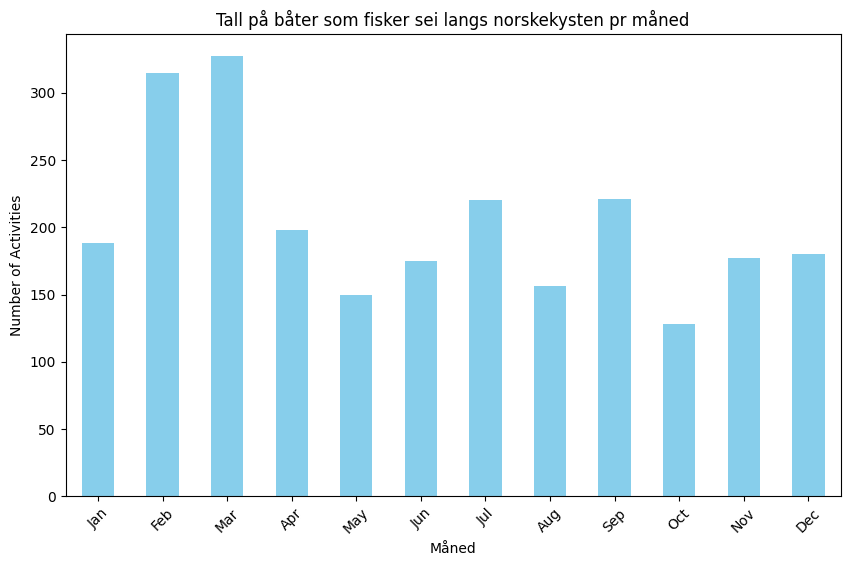

In [492]:
# Teller månedlig aktivitet.
monthly_counts = grouped_df.groupby('Month').size()

# Oppretter en serie for alle månedene i døgnet
all_months = pd.Series(0, index=range(1, 13))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_months.update(monthly_counts)

# Generer et diagram
plt.figure(figsize=(10, 6))
all_months.plot(kind='bar', color='skyblue')
plt.title(f'Tall på båter som fisker sei langs norskekysten pr måned')
plt.xlabel('Måned')
plt.ylabel('Number of Activities')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()



Vi ser her at det er mer aktivitet rundt seifiske i månedene februar og mars langs norskekysten. Det kan tenkes at dette har sammenheng med lofotfisket som foregår i månedene februar - april.

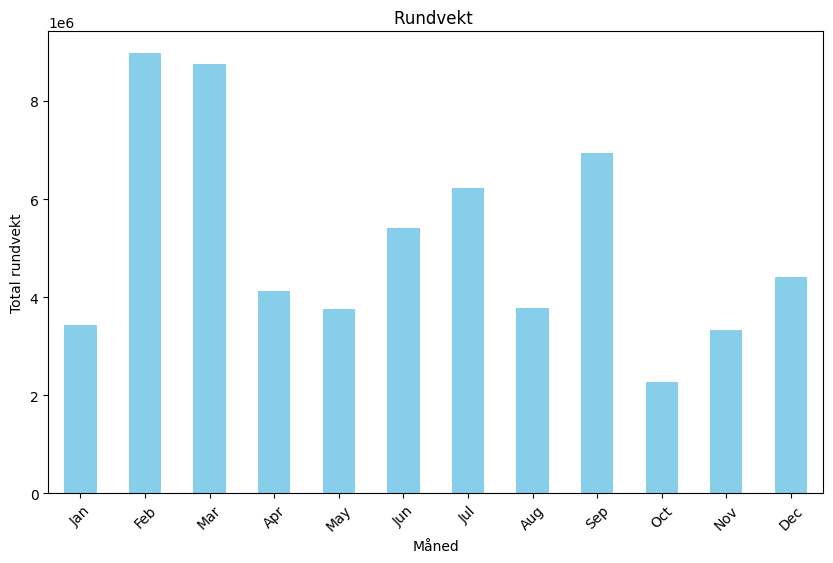

In [493]:
# Finner månedlig total rundvekt
monthly_weights = grouped_df.groupby('Month')['Rundvekt'].sum()

# Oppretter en serie for alle månedene i døgnet
all_months = pd.Series(0, index=range(1, 13))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_months.update(monthly_weights)

# Generer et diagram
plt.figure(figsize=(10, 6))
all_months.plot(kind='bar', color='skyblue')
plt.title(f'Rundvekt ')
plt.xlabel('Måned')
plt.ylabel('Total rundvekt')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

### 1.6.5 Samlet rundvekt av aktivitetene pr måned
Her ser vi tydelig sammenheng mellom månedene med stor aktivitet og den samlede rundvekten av aktivitetene.

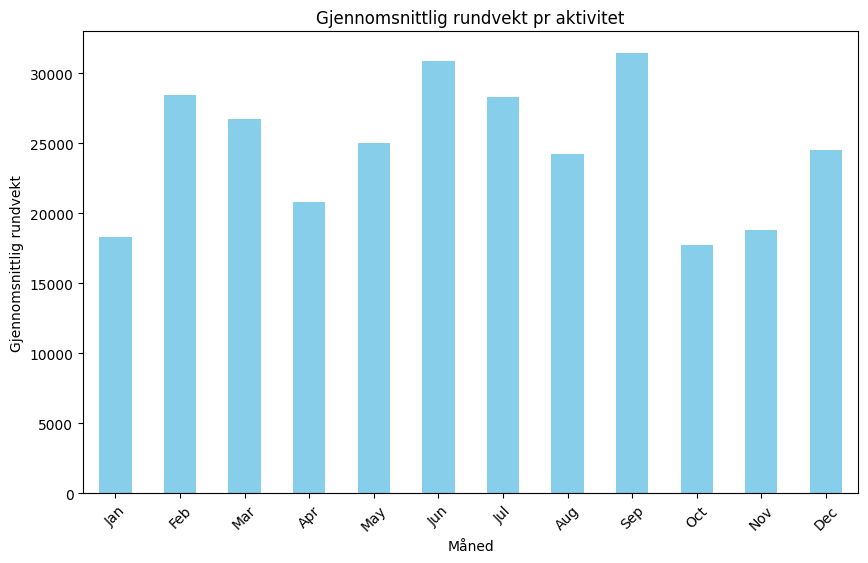

In [494]:
# Regner ut gjenomsnitt pr time
average_weights = monthly_weights/monthly_counts

# Oppretter en serie for alle timene i døgnet
all_months = pd.Series(0, index=range(1, 13))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_months.update(average_weights.astype(int))

# Generer et diagram
plt.figure(figsize=(10, 6))
all_months.plot(kind='bar', color='skyblue')
plt.title(f'Gjennomsnittlig rundvekt pr aktivitet')
plt.xlabel('Måned')
plt.ylabel('Gjennomsnittlig rundvekt')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

Ser at gjennomsnittlig vekt av seifiske holder seg stabilt i den forstand at den forventede fangsten holder seg relativt jevn gjennom året.
September utmerker seg likevel som en måned hvor det er forventet mer fisk.

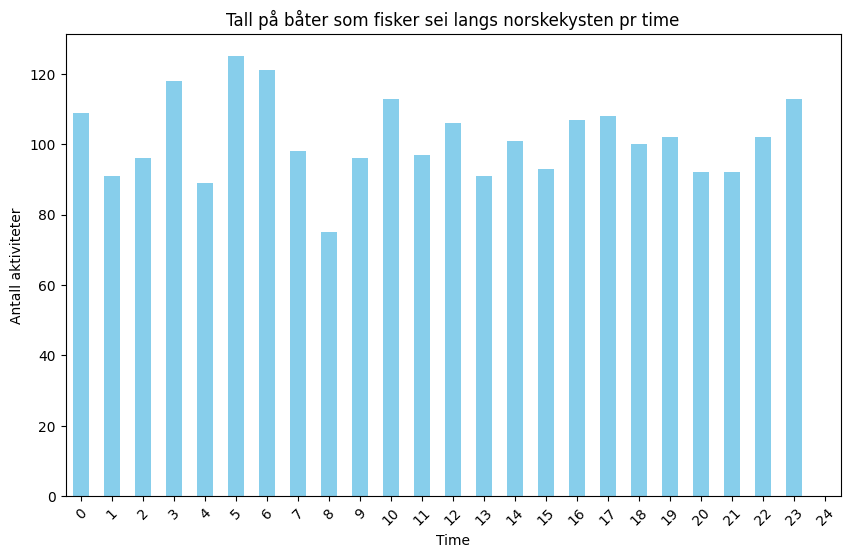

In [495]:
# Regner ut gjenomsnitt pr time
hourly_counts = grouped_df.groupby('Hours').size()

# Oppretter en serie for alle timene i døgnet
all_hours = pd.Series(0, index=range(0, 25))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_hours.update(hourly_counts)

# Generer et diagram
plt.figure(figsize=(10, 6))
all_hours.plot(kind='bar', color='skyblue')
plt.title(f'Tall på båter som fisker sei langs norskekysten pr time')
plt.xlabel('Time')
plt.ylabel('Antall aktiviteter')
plt.xticks(range(25), [x for x in range (0,25)], rotation=45)
plt.show()


Her ser vi hvordan fiskeaktivitetene av sei varierer i løpet av døgnet. Ser at det er en nokså stabil aktivitet gjennom døgnet. Her hadde vi forventet litt variasjoner.

Det finner det videre interessant å se på forholdet mellom aktivitetene og fangsten.

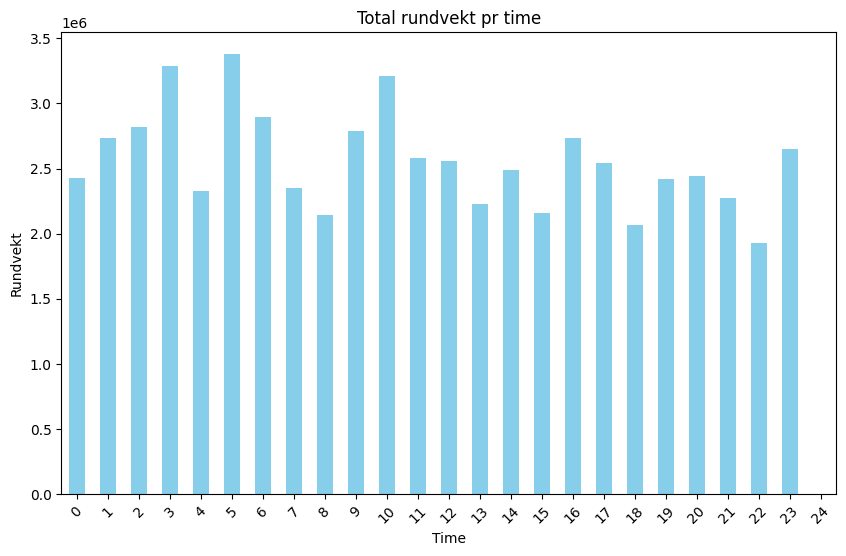

In [496]:
# Regner ut gjenomsnitt pr time
hourly_weights = grouped_df.groupby('Hours')['Rundvekt'].sum()

# Oppretter en serie for alle timene i døgnet
all_hours = pd.Series(0, index=range(0, 25))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_hours.update(hourly_weights)

# Generer et diagram
plt.figure(figsize=(10, 6))
all_hours.plot(kind='bar', color='skyblue')
plt.title(f'Total rundvekt pr time')
plt.xlabel('Time')
plt.ylabel('Rundvekt')
plt.xticks(range(25), [x for x in range (0,25)], rotation=45)
plt.show()

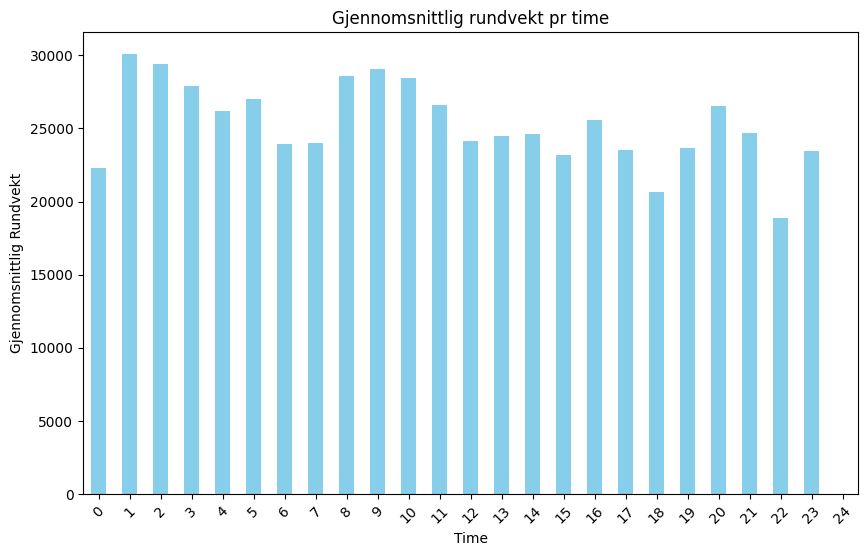

In [497]:
# Regner ut gjenomsnitt pr time
hourly_average = hourly_weights/hourly_counts

# Oppretter en serie for alle timene i døgnet
all_hours = pd.Series(0, index=range(0, 25))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_hours.update(hourly_average.astype(int))

# Generer et diagram
plt.figure(figsize=(10, 6))
all_hours.plot(kind='bar', color='skyblue')
plt.title(f'Gjennomsnittlig rundvekt pr time')
plt.xlabel('Time')
plt.ylabel('Gjennomsnittlig Rundvekt')
plt.xticks(range(25), [x for x in range (0,25)], rotation=45)
plt.show()

### 1.6.6 Tolking av data:
Det ser ut som seifisket med bunntrål fordeler seg ganske jevnt ut over døgnet og året, men med litt mer variasjon i løpet av året. Den beste fangsmåneden ser ut til å være i september om man ser på gjennomsnittlig fangst. Om noe forskjell i løpet av døgnet, så ser det ut som det det blir fanget noe mer fisk fra rundt midnatt til og med kl 11.

Selv om det er lite variasjoner på døgnet, kan det likevel være relevant for å predikere fiske. Det kan tenkes at det kan skyldes at fiske i nordlige deler på sommer eller vinterhalvåret gir naturlig en jevnere fordeling ila døgnet, siden forskjellene på natt og dag er mindre. Kanskje ville disse forskjellene være tydeligere i mer sørlige områder.


### 1.6.7 Omforming av tid

Om man skal bruke tid på døgnet må vi omforme dataene.
Maskinen og modellene vil tolke 00.01 og 23.59 som to verdier som er veldig langt ifra hverandre. Ved å omregne til sinus/radian løses dette, og vi får mer "sykliske" data.

In [498]:
grouped_df['Startklokkeslett'] = pd.to_datetime(grouped_df['Startklokkeslett'], format='%H:%M').dt.strftime('%H-%M')
# Konverter til Desimal-timer.
grouped_df['Startklokkeslett_DecimalHours'] = grouped_df['Startklokkeslett'].str.split('-').apply(lambda x: int(x[0]) + int(x[1]) / 60)
# Konverter til Radianer.
grouped_df['Startklokkeslett_Radians'] = grouped_df['Startklokkeslett_DecimalHours'] * (2 * np.pi / 24)
grouped_df.head()

Melding ID Meldingstidspunkt Meldingsdato Meldingsklokkeslett  \
0     1497341  01.01.2018 23:30   2018-01-01               23:30   
1     1497435  02.01.2018 07:50   2018-01-02               07:50   
2     1497823  02.01.2018 23:31   2018-01-02               23:31   
3     1497827  02.01.2018 23:31   2018-01-02               23:31   
4     1497843  02.01.2018 23:45   2018-01-02               23:45   

     Starttidspunkt   Startdato Startklokkeslett  Startposisjon bredde  \
0  01.01.2018 18:54  01.01.2018            18-54                61.283   
1  01.01.2018 03:21  01.01.2018            03-21                68.256   
2  02.01.2018 00:20  02.01.2018            00-20                68.535   
3  02.01.2018 18:02  02.01.2018            18-02                69.450   
4  02.01.2018 16:52  02.01.2018            16-52                63.122   

   Startposisjon lengde  Hovedområde start (kode)  ...  Bruttotonnasje 1969  \
0                 2.074                      28.0  ...               2053.0   
1                10.828                       5.0  ...               2580.0   
2                11.986                       5.0  ...               2580.0   
3                15.783                       5.0  ...                  NaN   
4                 5.381                       7.0  ...                536.0   

  Bruttotonnasje annen Bredde Fartøylengde  Bruttotonnasje kombinert  \
0                  NaN  13.00        75.50                    2053.0   
1                  NaN  14.60        64.00                    2580.0   
2                  NaN  14.60        64.00                    2580.0   
3                129.0   7.01        25.07                     129.0   
4                  NaN  10.30        33.95                     536.0   

   Bruttotonnasje gruppert  Hours  Month  Startklokkeslett_DecimalHours  \
0                        3     18      1                      18.900000   
1                        3      3      1                       3.350000   
2                        3      0      1                       0.333333   
3                        1     18      1                      18.033333   
4                        1     16      1                      16.866667   

  Startklokkeslett_Radians  
0                 4.948008  
1                 0.877028  
2                 0.087266  
3                 4.721116  
4                 4.415683  

[5 rows x 34 columns]

## 1.7: Slette kolonner
Datasettet vi arbeider med inneholder en stor mengde overflødig eller gjentakende informasjon som ikke er relevant videre. Vi har blant annet sett at informasjon om bruttotonnasje er fordelt på to kolonner. Vi har tidligere opprettet en ny kolonne hvor verdiene i disse to er kombinert. Vi kan dermed filtrere bort de opprinnelige kolonnene for bruttotonnasje videre.

Videre finnes det kolonner hvor dataene ikke er relevante. Dette gjelder blant annet tidspunkt for når meldingen er registrert, som ikke brukes til å predikere fiske i dette tilfellet, da meldingen kan ha vært sendt på et helt annet tidspunkt enn når fisket er gjennomført. Vi er interessert i faktisk tidspunkt og posisjon for fisket for å kunne si noe om resultater fra fisket.

Kolonner vi ikke ser som aktuelle å bruke videre vil nå slettes.


In [499]:
grouped_df.columns


Index(['Melding ID', 'Meldingstidspunkt', 'Meldingsdato',
       'Meldingsklokkeslett', 'Starttidspunkt', 'Startdato',
       'Startklokkeslett', 'Startposisjon bredde', 'Startposisjon lengde',
       'Hovedområde start (kode)', 'Havdybde start', 'Stopptidspunkt',
       'Stoppdato', 'Stoppklokkeslett', 'Varighet', 'Stopposisjon bredde',
       'Stopposisjon lengde', 'Havdybde stopp', 'Trekkavstand', 'Redskap FDIR',
       'Hovedart FAO', 'Rundvekt', 'Lengdegruppe (kode)', 'Lengdegruppe',
       'Bruttotonnasje 1969', 'Bruttotonnasje annen', 'Bredde', 'Fartøylengde',
       'Bruttotonnasje kombinert', 'Bruttotonnasje gruppert', 'Hours', 'Month',
       'Startklokkeslett_DecimalHours', 'Startklokkeslett_Radians'],
      dtype='object')

In [500]:

# Dropper kolonner: Vi hasher ut de kolonnene vi vil beholde.
grouped_df = grouped_df.drop(columns=[
    'Melding ID',
    'Meldingstidspunkt',
    'Meldingsdato',
    'Meldingsklokkeslett',
    'Starttidspunkt',
    'Startdato',
    'Startklokkeslett', # har konvertert
    #'Startposisjon bredde',
    #'Startposisjon lengde',
    'Hovedområde start (kode)',
    #'Havdybde start',
    'Stopptidspunkt', # Vi antar at det er liten forskjell på start og sluttidspunkt, så vi velger å droppe disse.
    'Stoppdato',
    'Stoppklokkeslett',
    'Varighet',
    'Stopposisjon bredde',
    'Stopposisjon lengde',
    #'Havdybde stopp', Kan være interessant å se på senere
    #'Trekkavstand',
    #'Redskap FDIR',
    #'Hovedart - FDIR (kode)',
    #'Rundvekt',
    'Lengdegruppe (kode)',
    'Lengdegruppe',
    'Bruttotonnasje 1969',
    'Bruttotonnasje annen',
    'Bredde',
    'Fartøylengde',
    #'Bruttotonnasje kombinert',
    # Bruttotonnasje gruppert,
    #'Hours',
    #'Month', Tar med måned videre.
    #'Startklokkeslett_DecimalHours',
    #'Startklokkeslett_Radians'
    ])

grouped_df.describe()

Startposisjon bredde  Startposisjon lengde  Havdybde start  \
count           2435.000000           2435.000000     2435.000000   
mean              66.993293             13.535374     -195.446817   
std                4.122621              8.446733       69.518209   
min               60.003000              2.013000     -757.000000   
25%               62.901000              5.340000     -231.000000   
50%               69.067000             14.233000     -188.000000   
75%               70.878000             20.653000     -152.000000   
max               71.998000             32.279000        1.000000   

       Havdybde stopp   Trekkavstand       Rundvekt  Bruttotonnasje kombinert  \
count     2435.000000    2435.000000    2435.000000               2435.000000   
mean      -197.847228   13788.480903   25220.546201               1954.348255   
std         72.816930   11453.148393   19736.864380               1153.251762   
min      -1276.000000       0.000000      16.000000                129.000000   
25%       -231.000000    5020.500000    9023.500000               1194.000000   
50%       -188.000000   10395.000000   21350.000000               1648.000000   
75%       -153.000000   19864.500000   37368.500000               3104.000000   
max        -72.000000  138228.000000  122392.000000               4427.000000   

             Hours        Month  Startklokkeslett_DecimalHours  \
count  2435.000000  2435.000000                    2435.000000   
mean     11.439836     5.977413                      11.917201   
std       6.959678     3.476045                       6.960786   
min       0.000000     1.000000                       0.000000   
25%       5.000000     3.000000                       5.816667   
50%      11.000000     6.000000                      11.900000   
75%      17.000000     9.000000                      17.916667   
max      23.000000    12.000000                      23.983333   

       Startklokkeslett_Radians  
count               2435.000000  
mean                   3.119916  
std                    1.822329  
min                    0.000000  
25%                    1.522800  
50%                    3.115413  
75%                    4.690572  
max                    6.278822

## 1.8: Rense nullverdier og ekstremer
Før vi skal bygge modellene våre, så ønsker vi å rense ut eventuelle nullverdier og ekstremer. Vi starter med en visuell beskrivelse av dataene, for å se etter tydelige avvik som med fordel kan fjernes.

Vi ser av df.describe at det finnes registreringer av rundvekt etter trål med verdien 0. Vi anser dette som feilregistreringer, ettersom en trål normalt soper store havområder. Videre vurderer vi det som lite trolig at et trålfiske har forekommet med 0 i trekkavstand.

På samme måte er det registreringer på over 200.000 meter. Dette er store avstander for en trål som vanligvis opererer i snittfart på mellom 3,4 (6,3km/h) og 5 knop (9,26 km/h). I en snittfart på 10km/h så vil da trålen bruke over 20 timer. Med så lang varighet vil det være svært ugunstige forhold for fisken. Vi ser og at 5% av registreringene er over 35.446 meter. Her ser vi også at med relativt høy fart, vil aktiviteten ha varighet på nærmere 4 timer. Ved å kutte registreringer over 50000m gir det en god margin på mulige feilregistreringer.

Vi ser videre at det er registrert positive havdybde-verdier. I tillegg er det også registrert aktiviteter på -1276 dybde. Men de aller fleste aktivitetene er registrert mellom -227 og -145 meter. Havforskningsinstituttet (2019) beskriver at "Sei førekjem både pelagisk og som botnfisk, frå 0 til 300 meters djup.". Derfor er det rimelig å anta at dette er enten feilregistreringer eller at fangsten er gjort når trålen er på vei opp av dypet.

Til slutt slås breddegrad og lengdegrad sammen til en posisjon, samt havdybde start og stopp.



Ser av trekkavstand at det i 0-registreringene av trekkavstand også fanges fisk. Dette gir ikke mening med tanke på at det følgelig må trekkes en viss avstand for å få fisk.

Ser også her at det er registrert forskjellige arter i 0-registrerningene på rundvekt. Det er da fornuftig å anta at dette enten er feilregistreringer eller fangst uten betydning.

In [501]:
# Får oversikt av de ulike verdiene:
print(grouped_df.info())
print(grouped_df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2435 entries, 0 to 2434
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Startposisjon bredde           2435 non-null   float64 
 1   Startposisjon lengde           2435 non-null   float64 
 2   Havdybde start                 2435 non-null   int64   
 3   Havdybde stopp                 2435 non-null   int64   
 4   Trekkavstand                   2435 non-null   float64 
 5   Redskap FDIR                   2435 non-null   object  
 6   Hovedart FAO                   2435 non-null   object  
 7   Rundvekt                       2435 non-null   float64 
 8   Bruttotonnasje kombinert       2435 non-null   float64 
 9   Bruttotonnasje gruppert        2357 non-null   category
 10  Hours                          2435 non-null   int32   
 11  Month                          2435 non-null   int32   
 12  Startklokkeslett_DecimalHours  243

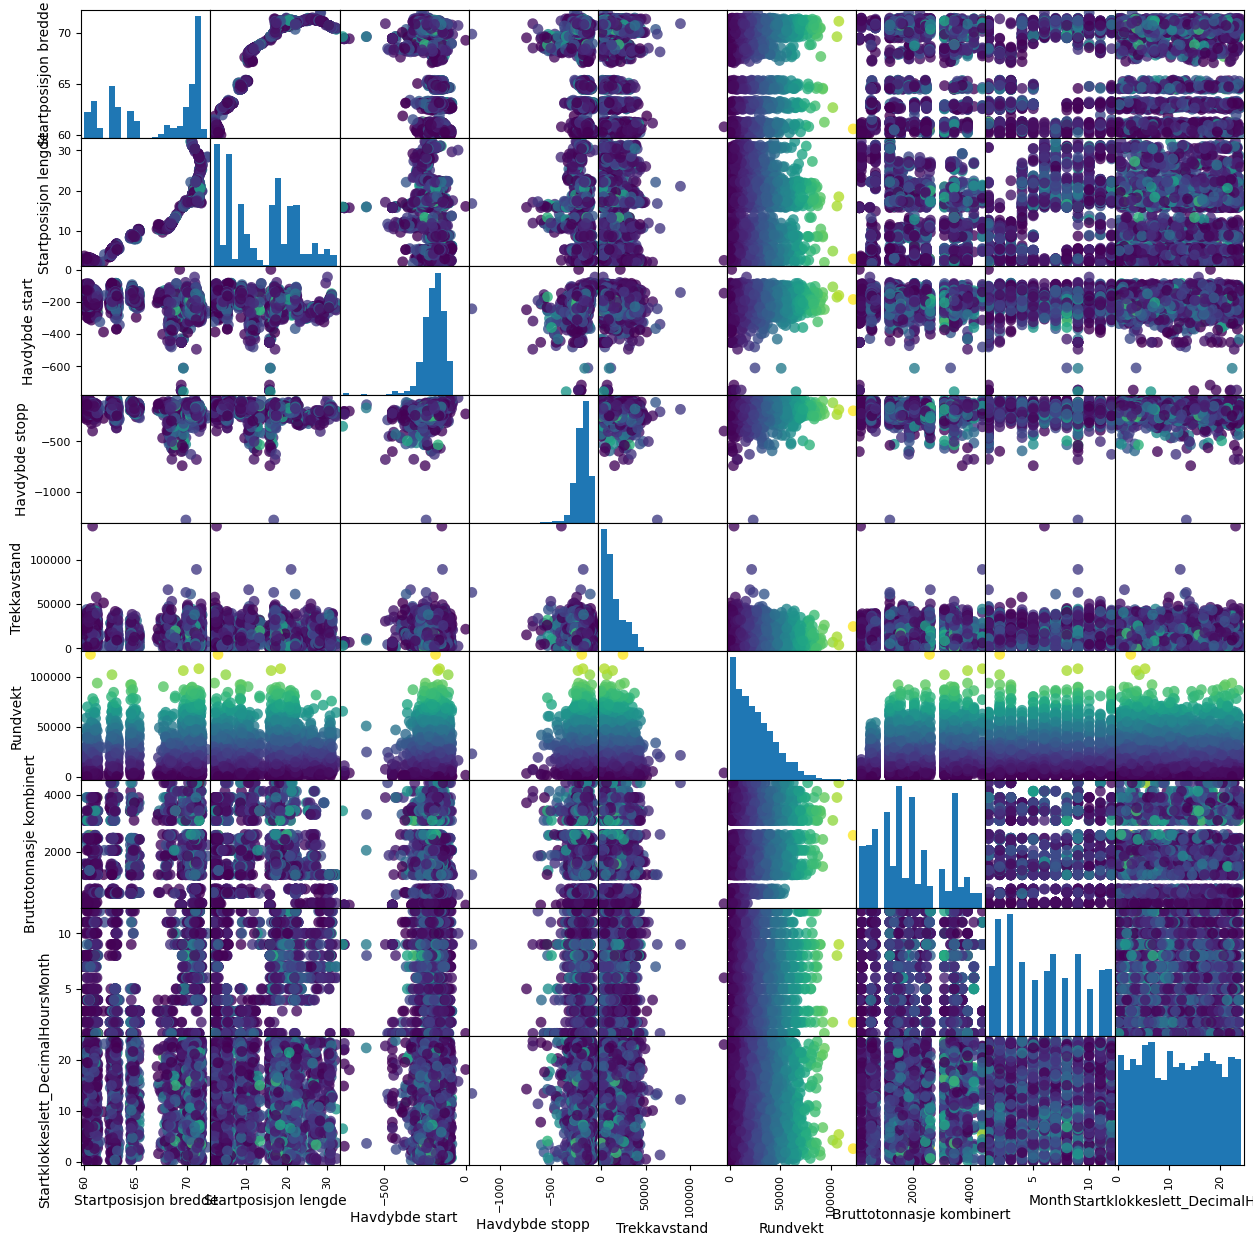

In [502]:
# Inkluderer de numeriske kolonnene
numeric_columns = ['Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start',
       'Havdybde stopp', 'Trekkavstand', 'Rundvekt', 'Bruttotonnasje kombinert',
       'Month', 'Startklokkeslett_DecimalHours']
plot_frame = grouped_df[numeric_columns]

# Genererer scatter matrix plot
grr = pd.plotting.scatter_matrix(
    plot_frame, c=plot_frame['Rundvekt'], figsize=(15, 15), marker='o', hist_kwds={'bins':20}, s=60, alpha=.8
    )

In [503]:
# Fjerner radene ekstremverdier og konverterer havdybdekolonnen:
# Droppe tomme rader.
cleaned_df = grouped_df.copy().dropna()
# Konvertere positive Havdybdeverdier
cleaned_df['Havdybde stopp'] = cleaned_df['Havdybde stopp'].abs()
cleaned_df['Havdybde start'] = cleaned_df['Havdybde start'].abs()
# fjerne havdybder over 700
cleaned_df = cleaned_df[cleaned_df['Havdybde stopp'] < 500]
cleaned_df = cleaned_df[cleaned_df['Havdybde start'] < 500]
# Ta vekk havdybder på over 10 m, for å fjerne usannsynlige tråledybder.
cleaned_df = cleaned_df[cleaned_df['Havdybde stopp'] > 10]
# Droppe trekkavstand på over 50000 m.
cleaned_df = cleaned_df[(cleaned_df['Trekkavstand'] > 0) & (cleaned_df['Trekkavstand'] < 50000)]
# Droppe Rundvekt med nullverdier:
cleaned_df = cleaned_df[cleaned_df['Rundvekt'] > 0]
# Droppe rundvekt med registreringer over 115000
cleaned_df = cleaned_df[cleaned_df['Rundvekt'] < 115000]


# Droppe ekstreme Bruttotonnasjeverdier.
cleaned_df = cleaned_df[(cleaned_df['Bruttotonnasje kombinert'] > 400) & (cleaned_df['Bruttotonnasje kombinert'] < 4000)]
# Droppe registreringer i områder som ikkje er i Norsk farvatn. Startposisjon med mindre enn 0.
cleaned_df = cleaned_df[cleaned_df['Startposisjon lengde'] > 0]
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2170 entries, 0 to 2434
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Startposisjon bredde           2170 non-null   float64 
 1   Startposisjon lengde           2170 non-null   float64 
 2   Havdybde start                 2170 non-null   int64   
 3   Havdybde stopp                 2170 non-null   int64   
 4   Trekkavstand                   2170 non-null   float64 
 5   Redskap FDIR                   2170 non-null   object  
 6   Hovedart FAO                   2170 non-null   object  
 7   Rundvekt                       2170 non-null   float64 
 8   Bruttotonnasje kombinert       2170 non-null   float64 
 9   Bruttotonnasje gruppert        2170 non-null   category
 10  Hours                          2170 non-null   int32   
 11  Month                          2170 non-null   int32   
 12  Startklokkeslett_DecimalHours  2170 non

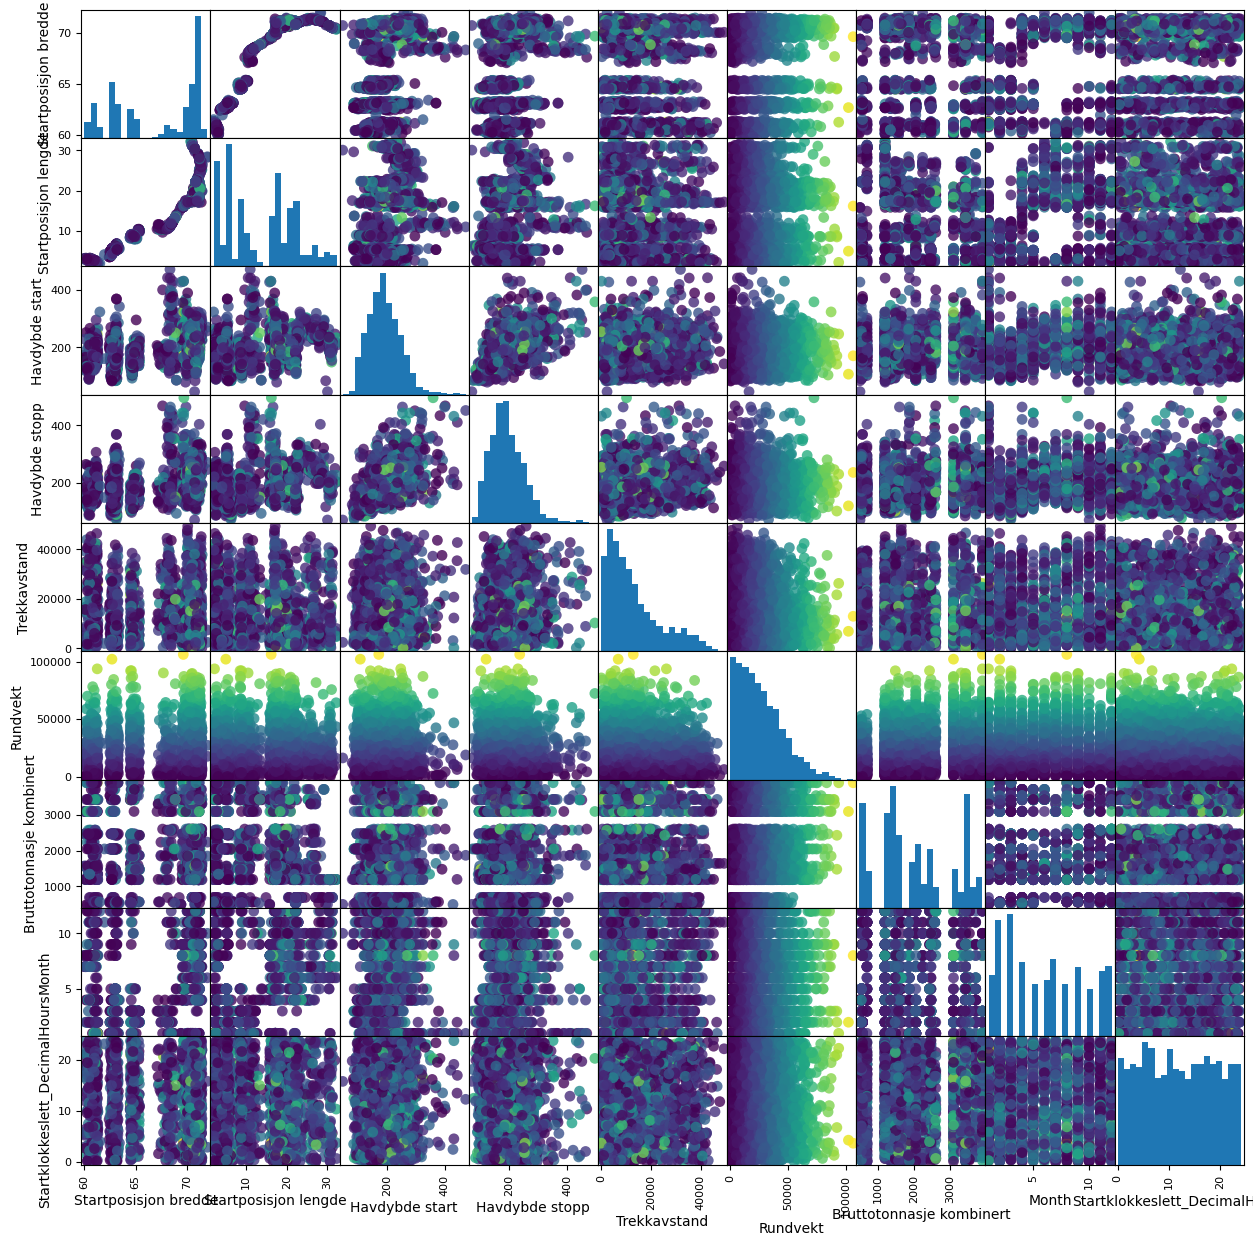

In [504]:
plot_frame = cleaned_df[numeric_columns]

grr = pd.plotting.scatter_matrix(
    plot_frame, c=plot_frame['Rundvekt'], figsize=(15, 15), marker='o', hist_kwds={'bins':20}, s=60, alpha=.8
    )

### Dimensjonel reduksjon:

In [505]:
from sklearn.decomposition import PCA
# Normalize the data
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(cleaned_df[['Startposisjon lengde', 'Startposisjon bredde']])

# Apply PCA
pca = PCA(n_components=1)
cleaned_df['position'] = pca.fit_transform(coords_scaled)

month_time_scaled = scaler.fit_transform(cleaned_df[['Month', 'Startklokkeslett_Radians']])
# Konvertere måned og time - Med tanke på at det kanskje er sammenheng mellom beste klokkeslett og når på året en fisker.
# For eksempel på vinter er det mørkere, og det kan kanskje påvirke ideelle tidspunkt for fiske:
cleaned_df['Month/time'] = pca.fit_transform(month_time_scaled)

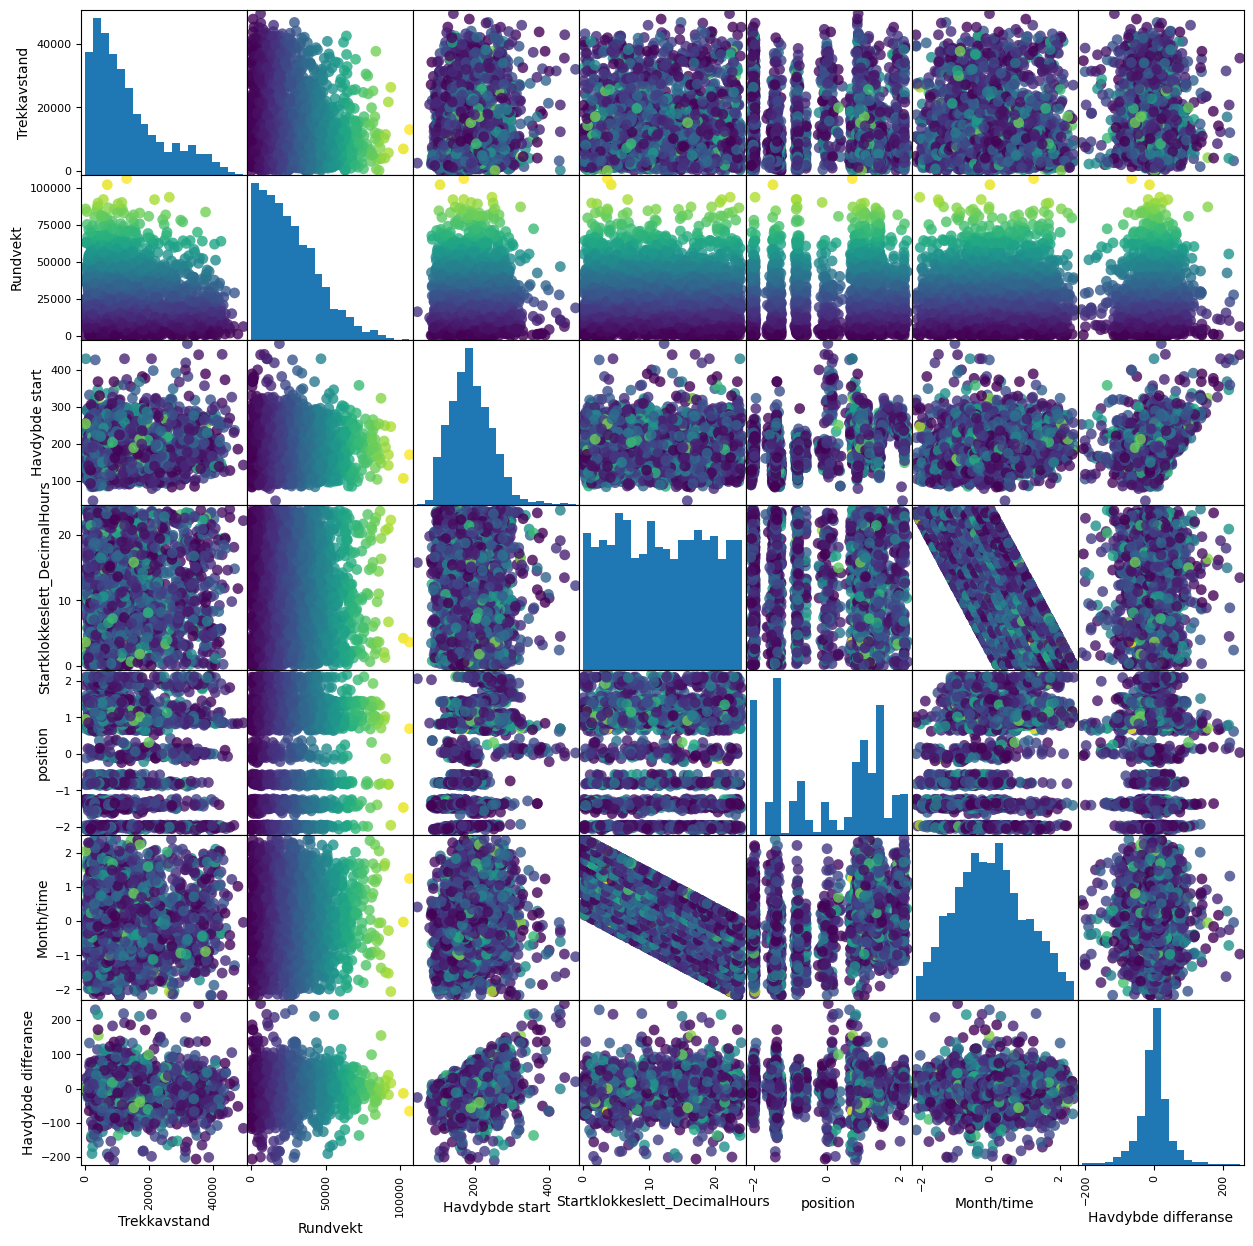

In [506]:
# Lager kolonne som tar ser om trålen dras i oppoverbakke eller nedoverbakke.
cleaned_df['Havdybde differanse'] = cleaned_df['Havdybde start'].abs()-cleaned_df['Havdybde stopp']

features = ['Trekkavstand', 'Rundvekt', 'Havdybde start', 'Startklokkeslett_DecimalHours', 'position', 'Month/time', 'Havdybde differanse']
plot_frame = cleaned_df[features]

# Generate the scatter matrix plot
grr = pd.plotting.scatter_matrix(
    plot_frame, c=plot_frame['Rundvekt'], figsize=(15, 15), marker='o', hist_kwds={'bins':20}, s=60, alpha=.8
)

In [507]:
# Fjerner ekstremer fra den nye kolonnen
cleaned_df = cleaned_df[(cleaned_df['Havdybde differanse'] > -150) & (cleaned_df['Havdybde differanse'] < 150)]

value_counts viser at de mest vanlige redskapene er bunntrål og snurrevad.

# 2: Supervised learning

## 2.1: KNN
Vi har valgt å starte med en KNN-Classifier modell. KNN kan beskrives som den enkleste maskinlæringsmodellen. Vi har valgt tidligere å fjerne ekstreme data, og vil og skalere dataen i denne modellen (Müller & Guido, 2017). Grunnen til at vi har valgt å begynne med en KNN-Classifier er fordi disse modellene er enkle å forstå og er en god start i prosessen for å gi en pekepinn videre på hvilke andre modeller som kan være aktuelle og hvilke justeringer som må gjøres.

In [508]:
# printer litt info om kolonnene
print(cleaned_df.columns)
print(cleaned_df.info())

Index(['Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start',
       'Havdybde stopp', 'Trekkavstand', 'Redskap FDIR', 'Hovedart FAO',
       'Rundvekt', 'Bruttotonnasje kombinert', 'Bruttotonnasje gruppert',
       'Hours', 'Month', 'Startklokkeslett_DecimalHours',
       'Startklokkeslett_Radians', 'position', 'Month/time',
       'Havdybde differanse'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 2134 entries, 0 to 2434
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Startposisjon bredde           2134 non-null   float64 
 1   Startposisjon lengde           2134 non-null   float64 
 2   Havdybde start                 2134 non-null   int64   
 3   Havdybde stopp                 2134 non-null   int64   
 4   Trekkavstand                   2134 non-null   float64 
 5   Redskap FDIR                   2134 non-null   object  
 6   Hovedart FAO 

In [509]:
# Lager kolonne som tar ser om trålen dras i oppoverbakke eller nedoverbakke.
cleaned_df['Havdybde differanse'] = cleaned_df['Havdybde start'].abs()-cleaned_df['Havdybde stopp']

<ipython-input-509-7599d0403b6e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['Havdybde differanse'] = cleaned_df['Havdybde start'].abs()-cleaned_df['Havdybde stopp']


In [510]:
# Velger aktuelle features:
selected_features = [
    'Trekkavstand',
    'Bruttotonnasje kombinert',
    'position',
    'Month/time',
    'Havdybde differanse',
    'Havdybde start'
    ]
# Kan ikke bruke rundvekt som target i knn-classifier, så vi må konvertere til kategorisk data.
target = ['Rundvekt']

### Q-binning

In [511]:
# Grupperer rundvekt i fire kategorier, for at den skal kunne brukes med kNN-klassifier
labels = ['bad catch', 'Below Average', 'Above average', 'Good catch']

num_bins = 4  # Antall grupper
labels = ['Q1', 'Q2', 'Q3', 'Q4']  # lager fire grupper
cleaned_df['Q-binned'] = pd.qcut(cleaned_df['Rundvekt'], q=num_bins, labels=labels)
cleaned_df['Q-binned'].value_counts()

<ipython-input-511-722db71256cd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['Q-binned'] = pd.qcut(cleaned_df['Rundvekt'], q=num_bins, labels=labels)


Q-binned
Q1    534
Q4    534
Q2    533
Q3    533
Name: count, dtype: int64

In [512]:
# Kalkulerer gjennomsnittsrundvekten.
mean_catch_weight = cleaned_df['Rundvekt'].mean()
# Finner standardavviket.
std_dev_catch_weight = cleaned_df['Rundvekt'].std()

# Definerer bins, basert på standardavvik.
lower_bound = mean_catch_weight - std_dev_catch_weight
upper_bound = mean_catch_weight + std_dev_catch_weight

cleaned_df['std-binned'] = pd.cut(cleaned_df['Rundvekt'],
                                      bins=[-np.inf, lower_bound, mean_catch_weight, upper_bound, np.inf],
                                      labels=labels)

print('Standardfordeling:', std_dev_catch_weight)
print('Gjennomsnittsfangst:', mean_catch_weight)

cleaned_df[['std-binned']].value_counts()

Standardfordeling: 19224.33308682004
Gjennomsnittsfangst: 26362.759137769448


<ipython-input-512-b03738d7d9e1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['std-binned'] = pd.cut(cleaned_df['Rundvekt'],


std-binned
Q2            849
Q3            589
Q1            352
Q4            344
Name: count, dtype: int64

Scaling

Min-max

prøver ut Min-max på Q-binned

In [513]:
# Setter target til Q-binned.
target = 'Q-binned'

X = cleaned_df[selected_features]
y = cleaned_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Gir de ulike klassene numeriske verdier.
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [514]:
# Skalerer features (for kNN)
scaler = MinMaxScaler(feature_range=(0,1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [515]:
# KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_scaled, y_train_encoded)
y_pred_knn_classifier = knn_classifier.predict(X_test_scaled)

# Printer score
accuracy = accuracy_score(y_test_encoded, y_pred_knn_classifier)
print(f"KNN Classifier Score: {accuracy}")

KNN Classifier Score: 0.2576112412177986


### Standardscaler:

Forsøker på nytt med standardscaler

In [516]:
# Skalerer
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_scaled, y_train_encoded)
y_pred_knn_classifier = knn_classifier.predict(X_test_scaled)

# Evaluate the classifier
accuracy = accuracy_score(y_test_encoded, y_pred_knn_classifier)
print(f"KNN Classifier Score: {accuracy}")

KNN Classifier Score: 0.26229508196721313


Ser at Min-max scorer noe bedre enn standardscaler

###Videre undersøkelser og grid-search

Tester standardfordelte grupper for målverdi:

In [517]:
# Setter target til std-fordelt gruppering std-binned.
new_target = 'std-binned'

# Setter scaler tilbake til min-max
scaler = MinMaxScaler(feature_range=(0,1))
X = cleaned_df[selected_features]
y = cleaned_df[new_target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_scaled, y_train_encoded)
y_pred_knn_classifier = knn_classifier.predict(X_test_scaled)

# Evaluate the classifier
accuracy = accuracy_score(y_test_encoded, y_pred_knn_classifier)
print(f"KNN Classifier Score: {accuracy}")


KNN Classifier Score: 0.3700234192037471


In [518]:
# Genererer en dictionary med parameterene vi vil tune. Hvor mange naboer, algoritme,
# Hvordan modellen vektlegger og hvordan modellen regner avstand.
param_grid = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute']
}

# Genererer gridsearch-objekt
grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
# fitting.
grid_search.fit(X_train_scaled, y_train_encoded)
# Finner beste resultat
best_knn = grid_search.best_estimator_
# Predikerer ved bruk av beste modell.
y_pred = best_knn.predict(X_test_scaled)

# Skriver ut score.
accuracy = accuracy_score(y_test_encoded, y_pred)
print(
    f'Beste kNN Classifier Score med :\n Naboer: {best_knn.n_neighbors}\n Vekter: "{best_knn.weights}"\n Metric: "{best_knn.metric}"\n Algoritme: "{best_knn.algorithm}"\nNøyaktighet: "{accuracy}"'
      )

Beste kNN Classifier Score med :
 Naboer: 10
 Vekter: "uniform"
 Metric: "euclidean"
 Algoritme: "ball_tree"
Nøyaktighet: "0.3559718969555035"


Ser at den standardfordelte inndelingen av target fungerer bedre, samt at MinMaxScaler gir bedre resultat.
Vi prøver videre med grid-search etter de beste parametrene.

In [519]:
for x in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    knn_classifier = KNeighborsClassifier(n_neighbors=x)
    knn_classifier.fit(X_train_scaled, y_train_encoded)
    y_pred_knn_classifier = knn_classifier.predict(X_test_scaled)

    # Evaluate the classifier
    accuracy = accuracy_score(y_test_encoded, y_pred_knn_classifier)
    print(f"KNN Classifier Score for {x} naboer: {accuracy}")

KNN Classifier Score for 2 naboer: 0.3231850117096019
KNN Classifier Score for 3 naboer: 0.32786885245901637
KNN Classifier Score for 4 naboer: 0.34192037470725994
KNN Classifier Score for 5 naboer: 0.3700234192037471
KNN Classifier Score for 6 naboer: 0.3559718969555035
KNN Classifier Score for 7 naboer: 0.36768149882903983
KNN Classifier Score for 8 naboer: 0.3629976580796253
KNN Classifier Score for 9 naboer: 0.37236533957845436
KNN Classifier Score for 10 naboer: 0.3559718969555035


In [520]:
for x in ['dice', 'chebyshev', 'euclidean', 'manhattan', 'russellrao', 'sokalsneath', 'l2', 'nan_euclidean', 'correlation', 'rogerstanimoto', 'cosine', 'infinity', 'cityblock', 'minkowski', 'l1', 'canberra', 'sqeuclidean', 'braycurtis', 'hamming', 'p', 'sokalmichener', 'jaccard']:
    knn_classifier = KNeighborsClassifier(n_neighbors=9, metric=x)
    knn_classifier.fit(X_train_scaled, y_train_encoded)
    y_pred_knn_classifier = knn_classifier.predict(X_test_scaled)

    # Evaluate the classifier
    accuracy = accuracy_score(y_test_encoded, y_pred_knn_classifier)
    print(f"KNN Classifier Score for {x} naboer: {accuracy}")

KNN Classifier Score for dice naboer: 0.3840749414519906
KNN Classifier Score for chebyshev naboer: 0.35362997658079626
KNN Classifier Score for euclidean naboer: 0.37236533957845436
KNN Classifier Score for manhattan naboer: 0.36533957845433257
KNN Classifier Score for russellrao naboer: 0.3840749414519906
KNN Classifier Score for sokalsneath naboer: 0.3840749414519906
KNN Classifier Score for l2 naboer: 0.37236533957845436
KNN Classifier Score for nan_euclidean naboer: 0.37236533957845436
KNN Classifier Score for correlation naboer: 0.3864168618266979
KNN Classifier Score for rogerstanimoto naboer: 0.3840749414519906
KNN Classifier Score for cosine naboer: 0.40046838407494145
KNN Classifier Score for infinity naboer: 0.35362997658079626
KNN Classifier Score for cityblock naboer: 0.36533957845433257
KNN Classifier Score for minkowski naboer: 0.37236533957845436
KNN Classifier Score for l1 naboer: 0.36533957845433257
KNN Classifier Score for canberra naboer: 0.3583138173302108
KNN Clas

In [521]:
# Genererer en dictionary med parameterene vi vil tune. Hvor mange naboer, algoritme,
# Hvordan modellen vektlegger og hvordan modellen regner avstand.
param_grid = {
    'n_neighbors': [3, 4, 5, 6, 7, 8, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute']
}

# Genererer gridsearch-objekt
grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
# fitting.
grid_search.fit(X_train_scaled, y_train_encoded)
# Finner beste resultat
best_knn = grid_search.best_estimator_
# Predikerer ved bruk av beste modell.
y_pred = best_knn.predict(X_test_scaled)

# Skriver ut score.
accuracy = accuracy_score(y_test_encoded, y_pred)
print(
    f'Beste kNN Classifier Score med :\n Naboer: {best_knn.n_neighbors}\n Vekter: "{best_knn.weights}"\n Metric: "{best_knn.metric}"\n Algoritme: "{best_knn.algorithm}"\nNøyaktighet: "{accuracy}"'
      )

Beste kNN Classifier Score med :
 Naboer: 10
 Vekter: "uniform"
 Metric: "euclidean"
 Algoritme: "ball_tree"
Nøyaktighet: "0.3559718969555035"


Vi har testet forskjellige måter å klassifisere målverdiene på, og ser at i denne modellen så fungerte det best ved standardfordeling. Videre gjorde vi grid-search for å teste ut ideelle antall naboer i modellen, hvor vi landet på 9. Ved å søke igjennom ulike måter å måle avstand på ser vi også at metric=cosine, gir best resultat.

Vi prøvde modulen GridSearchCV som automatisk skal finne de beste parametrene. Denne ga i dette tilfellet dårlig resultat, dog kan dette være grunnet at den ikke fant en bedre parameter i rangen vi anga.

## 2.2 Decision tree Classifier
Decision trees er en supervised læringsmodell som både blir brukt til klassifikasjon og regresjon. Den fungerer ved at den stiller en rekke «hvis/hvis ikke-spørsmål» for å komme fram til en «beslutning», altså en klasse eller en verdi (Müller & Guido, 2017).

In [522]:
cleaned_df.columns

Index(['Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start',
       'Havdybde stopp', 'Trekkavstand', 'Redskap FDIR', 'Hovedart FAO',
       'Rundvekt', 'Bruttotonnasje kombinert', 'Bruttotonnasje gruppert',
       'Hours', 'Month', 'Startklokkeslett_DecimalHours',
       'Startklokkeslett_Radians', 'position', 'Month/time',
       'Havdybde differanse', 'Q-binned', 'std-binned'],
      dtype='object')

In [523]:
# På grunn av trestrukturen i decision tree, så er det ikke nødvendig med skalerte features.
dc_features = [
    'Startposisjon bredde',
    'Startposisjon lengde',
    'Havdybde start',
    'Havdybde stopp',
    'Trekkavstand',
    #'Redskap FDIR',
    #'Hovedart FAO',
    #'Rundvekt',
    #'Bruttotonnasje kombinert',
    'Bruttotonnasje gruppert',
    'Month',
    'Hours',
    #'Startklokkeslett_DecimalHours',
    #'Startklokkeslett_Radians',
    #'position',
    #'Month/time',
    'Havdybde differanse',
    #'Q-binned',
    #'std-binned'
    ]
dc_target  = 'std-binned'

# Definerer X og y
X = cleaned_df[dc_features]
y = cleaned_df[dc_target]

# Splitter
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


for x in range(1,10):
    # Oppretter modellen
    dtree = DecisionTreeClassifier(max_depth=x, criterion='gini')

    # Tilpasser modellen til settet
    dtree.fit(X_train, y_train)

    # Gjør prediksjoner
    y_pred = dtree.predict(X_test)

    # score.
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of Decision Tree classifier, max depth: {x}, : {accuracy:.2f}")

Accuracy of Decision Tree classifier, max depth: 1, : 0.38
Accuracy of Decision Tree classifier, max depth: 2, : 0.38
Accuracy of Decision Tree classifier, max depth: 3, : 0.39
Accuracy of Decision Tree classifier, max depth: 4, : 0.38
Accuracy of Decision Tree classifier, max depth: 5, : 0.38
Accuracy of Decision Tree classifier, max depth: 6, : 0.37
Accuracy of Decision Tree classifier, max depth: 7, : 0.41
Accuracy of Decision Tree classifier, max depth: 8, : 0.41
Accuracy of Decision Tree classifier, max depth: 9, : 0.38


In [524]:
for x in [6, 10, 13, 15, 17, 20, 30]:
    # Oppretter modellen
    dtree = DecisionTreeClassifier(max_depth=7, criterion='gini', min_samples_split=x)

    # Tilpasser modellen til settet
    dtree.fit(X_train, y_train)

    # Gjør prediksjoner
    y_pred = dtree.predict(X_test)

    # score.
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of Decision Tree classifier, min_samples_split: {x}, : {accuracy:.2f}")

Accuracy of Decision Tree classifier, min_samples_split: 6, : 0.41
Accuracy of Decision Tree classifier, min_samples_split: 10, : 0.41
Accuracy of Decision Tree classifier, min_samples_split: 13, : 0.41
Accuracy of Decision Tree classifier, min_samples_split: 15, : 0.42
Accuracy of Decision Tree classifier, min_samples_split: 17, : 0.42
Accuracy of Decision Tree classifier, min_samples_split: 20, : 0.40
Accuracy of Decision Tree classifier, min_samples_split: 30, : 0.40


In [525]:
for x in [1, 2, 4, 5, 6, 8]:
    # Oppretter modellen
    dtree = DecisionTreeClassifier(max_depth=7, criterion='gini', min_samples_split=15, min_samples_leaf=x)

    # Tilpasser modellen til settet
    dtree.fit(X_train, y_train)

    # Gjør prediksjoner
    y_pred = dtree.predict(X_test)

    # score.
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of Decision Tree classifier, min_samples_leaf: {x}, : {accuracy:.2f}")

Accuracy of Decision Tree classifier, min_samples_leaf: 1, : 0.42
Accuracy of Decision Tree classifier, min_samples_leaf: 2, : 0.42
Accuracy of Decision Tree classifier, min_samples_leaf: 4, : 0.43
Accuracy of Decision Tree classifier, min_samples_leaf: 5, : 0.43
Accuracy of Decision Tree classifier, min_samples_leaf: 6, : 0.43
Accuracy of Decision Tree classifier, min_samples_leaf: 8, : 0.41


**Resultat**

Ved grid-search så kommer vi fram til et decision tree som har max-dybde på 7, min_samples_split=15, og min_samples_leaf=5. Det gav oss et resultat på 0.43 som vil si at den predikerer med mye usikkerhet.

Det gir følgende decision tree.

In [526]:
dtree = DecisionTreeClassifier(max_depth=7, criterion='gini', min_samples_split=15, min_samples_leaf=5)

dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)

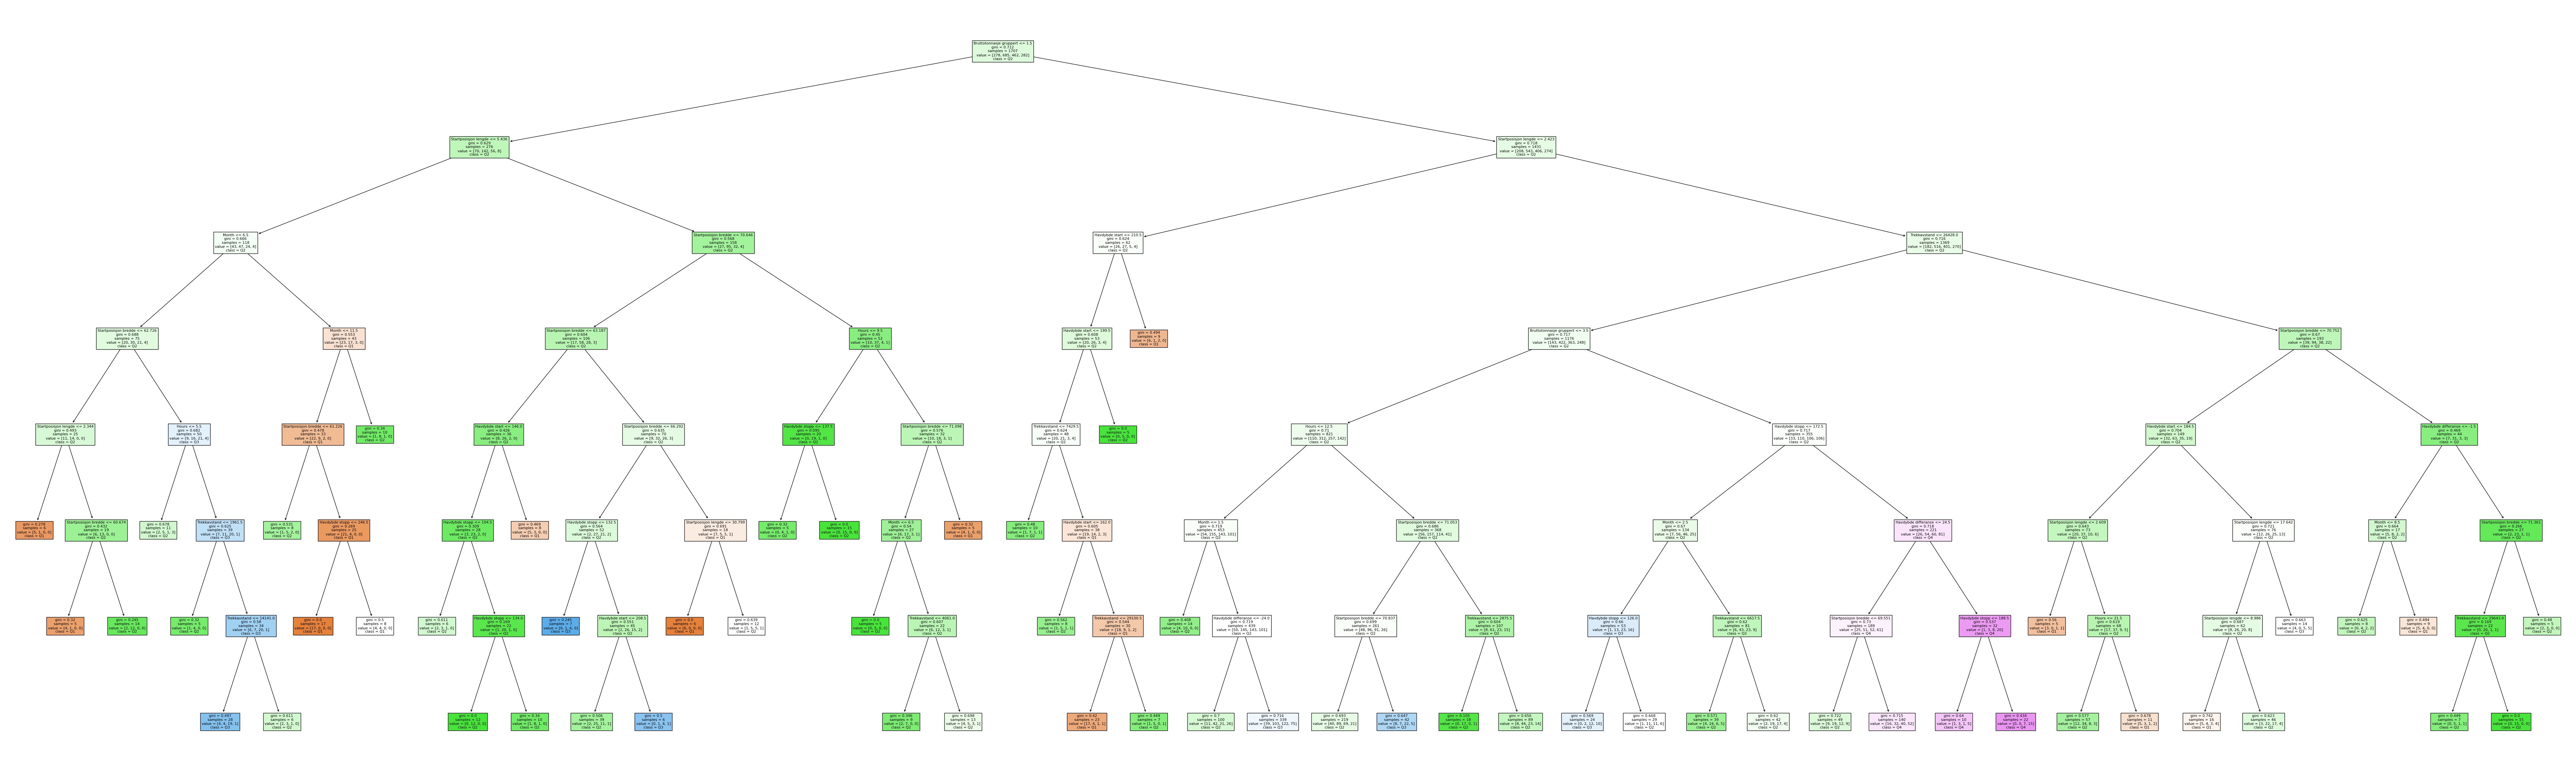

In [527]:
plt.figure(figsize=(100, 30))
plot_tree(dtree, filled=True, feature_names=dc_features, class_names=labels)
plt.show()

## 2.3: MLP regressor


In [528]:
# Sjekker hvilke kolonner som vi har i settet.
cleaned_df.columns

Index(['Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start',
       'Havdybde stopp', 'Trekkavstand', 'Redskap FDIR', 'Hovedart FAO',
       'Rundvekt', 'Bruttotonnasje kombinert', 'Bruttotonnasje gruppert',
       'Hours', 'Month', 'Startklokkeslett_DecimalHours',
       'Startklokkeslett_Radians', 'position', 'Month/time',
       'Havdybde differanse', 'Q-binned', 'std-binned'],
      dtype='object')

##Valg av features

In [529]:
# Velger ut kolonner vi vil bruke videre i modellen. Vi dropper redskap og hovedart siden de inneholder sei og bunntrål
# Dropper rundvekt, og de binnede rundvektene siden de er target value.
# Dropper Bruttotonnasje gruppert, siden vi bruker regresjonsmodellen og tenker det er bedre å bruke flytende verdier.
mlp_features = [
    'Startposisjon bredde',
    'Startposisjon lengde',
    'Havdybde start',
    'Havdybde stopp',
    'Trekkavstand',
    'Bruttotonnasje kombinert',
    'Hours',
    'Month',
    'Startklokkeslett_Radians',
    'position',
    'Month/time',
    'Havdybde differanse'
    ]
y = cleaned_df['Rundvekt']
X = cleaned_df[mlp_features] #Dropper rundvekt pga det er hva vi trener modellen på


In [530]:
# Splitter datasettet
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1) #Test størrelse = 20% av datasettet

# Gjør MinMaxScaler
scaler = MinMaxScaler()

X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)

In [531]:
nn = MLPRegressor(hidden_layer_sizes = [20,10], #Første lag har 20 neurons, andre lag har 10.
                  activation = 'relu', alpha = 0.1,
                  max_iter = 2000, #Maks iterasjoner du gjør men det er egentlig epocs. usikker på hvorfor de bruker 'itterations' og not 'epocs'
                  early_stopping = True, #Early stopping introduserte ustabilitet. men med en iter på 2000 maks så skal det ikke ta alt for lang tid på de fleste pcer.
                  learning_rate_init = 0.1,#Start på learning rate, den blir adaptet etter hvert angående på loss verdien
                  learning_rate = "adaptive",
                  solver = 'adam',
                  verbose = False,
                  random_state=1)

#Test score uten data leak. (bruker minmax etter splitting)
nn.fit(X_train_minmax, y_train)
print("Neural network, MLPRegressor")
print("Test score",  nn.score(X_test_minmax, y_test))
print("Train  score", nn.score(X_train_minmax, y_train))

Neural network, MLPRegressor
Test score 0.09056663476607951
Train  score 0.09610776257956477


In [532]:
sc=StandardScaler()

#scaler = sc.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [533]:
nn = MLPRegressor(hidden_layer_sizes = [20,10], #Første lag har 20 neurons, andre lag har 10.
                  activation = 'relu', alpha = 0.1,
                  max_iter = 2000, #Maks itterasjoner du gjør men det er egentlig epocs. usikker på hvorfor de bruker 'itterations' og not 'epocs'
                #   early_stopping=True, #Early stopping introduserte ustabilitet. men med en iter på 2000 maks så skal det ikke ta alt for lang tid på de fleste pcer.
                  learning_rate_init=0.1,#Start på learning rate, den blir adaptet etter hvert angående på loss verdien
                  learning_rate="adaptive",
                  solver = 'adam',
                  verbose = False)

In [534]:
#Test score uten data leak. (bruker minmax etter splitting)
nn.fit(X_train_minmax, y_train)
print("Neural network, MLPRegressor")
print("Test score",  nn.score(X_test_minmax, y_test))
print("Train  score", nn.score(X_train_minmax, y_train))

Neural network, MLPRegressor
Test score 0.09689251692942458
Train  score 0.09785033480478178


**Resultat**

lav score

Vi observerer at det er et «overfitting» problem i modellen som skaper noen vanskeligheter, dog er resultatene relativt gode.

One-hot encoding kan hjelpe med dette gjennom å få tak i mer data samt strategier som early stopping. Et annet forbedringspotensial hadde vært å få brukt «regularization techniques».


# 3: Unsupervised learning


## 3.1: Clustering
Vi vil nå utføre en K-means clustering. Målet er å finne «cluster centers» som er representative for noen områder med data. (Müller & Guido, 2017).

In [535]:
#Importerer nødvendige libararies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

Her preprosesseres dataen på nytt, siden det skal filtreres på andre ting enn i del 1.

Målet med modellen er å predikere hvilke fisk som fanges basert på ulike variabler.

In [536]:
df_clustering = df
desired_fish = ['Sei', 'Dypvannsreke', 'Taskekrabbe'] #Ønsket fisk vi vil filtere på
filtered_data = df_clustering[ df_clustering['Art FAO'].isin(desired_fish)] #Beholder kun data på fisketurer hvor det er fisket de ønskede fiskene

features = ["Rundvekt", "Havdybde start", "Havdybde stopp", "Trekkavstand", "Art FAO", ] #liste over de ulike variablene vi ønsker å ha med

ekstra = filtered_data.dropna(subset=features) #Fjerner rader med n/a verdier

data_clustering1 = ekstra[features].copy()

data_clustering_cleaned =data_clustering1.drop(columns= ['Art FAO']) #Fjerner så alle variabler som er strings



data_clustering_cleaned.head()

Rundvekt  Havdybde start  Havdybde stopp  Trekkavstand
4      134.0            -335            -334        3970.0
9       67.0            -403            -277       11096.0
14      68.0            -346            -496       10215.0
26    2895.0           -1090           -1090           0.0
37     336.0            -124            -130       22467.0

In [537]:
#fjerner outliers

Q1 = data_clustering_cleaned.quantile(0.25)
Q3 = data_clustering_cleaned.quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = data_clustering_cleaned[((data_clustering_cleaned < (Q1 - 1.5 * IQR)) | (data_clustering_cleaned > (Q3 + 1.5 * IQR))).any(axis=1)]
clustering_data = data_clustering_cleaned[~data_clustering_cleaned.index.isin(outliers_iqr.index)]


clustering_data.head()

Rundvekt  Havdybde start  Havdybde stopp  Trekkavstand
4      134.0            -335            -334        3970.0
9       67.0            -403            -277       11096.0
37     336.0            -124            -130       22467.0
42     240.0            -139            -145       23342.0
46      96.0            -148            -153       21053.0

In [538]:
#Skalerer nødvendig data

scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data[['Rundvekt', 'Havdybde start', 'Havdybde stopp', 'Trekkavstand']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

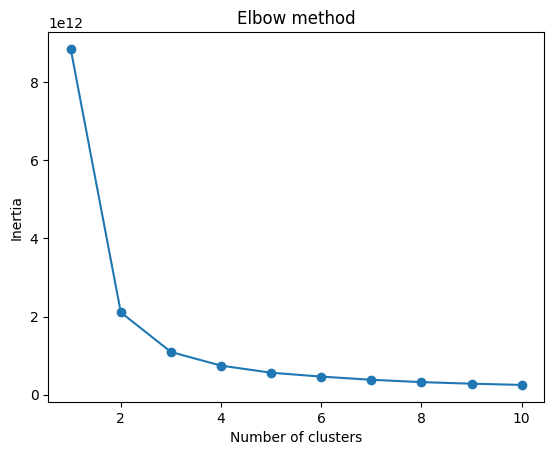

In [539]:
#Bruker elbow metoden for å finne den optimale k

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(clustering_data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Basert på resultatene fra elbow metoden velger vi å sette k=3

In [540]:
#anvender K-Means clusteringen

k=3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(scaled_data)
#clustering_data['cluster'] = kmeans.labels_
y_pred = kmeans.predict(scaled_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Visualiserer clusters

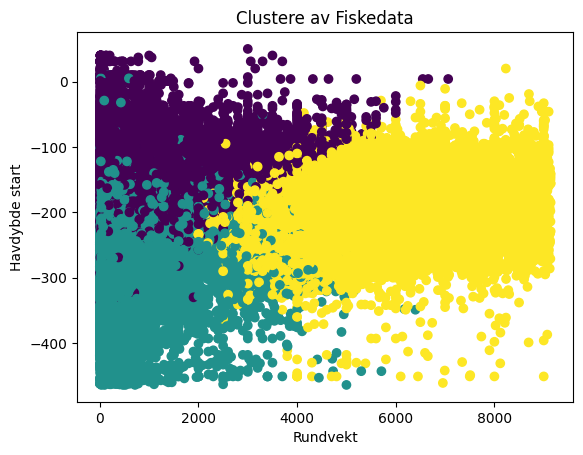

In [541]:
#1. Ser på sammenheng mellom rundvekt og havdybde start
plt.scatter(clustering_data['Rundvekt'], clustering_data['Havdybde start'], c=y_pred, cmap='viridis')
plt.xlabel('Rundvekt')
plt.ylabel('Havdybde start')

plt.title('Clustere av Fiskedata')
plt.show()

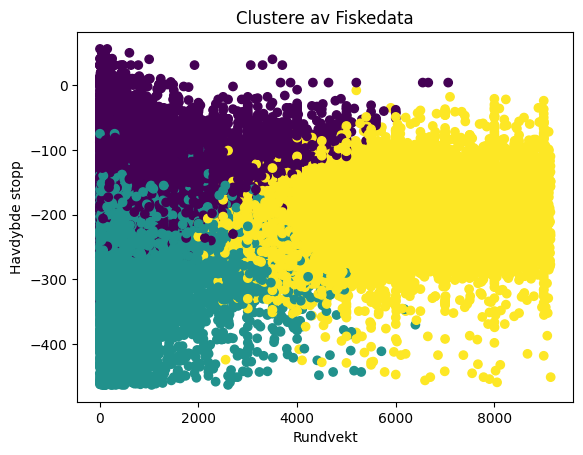

In [542]:
#2. Ser på sammenheng mellom rundvekt og havdybde stopp
plt.scatter(clustering_data['Rundvekt'], clustering_data['Havdybde stopp'], c=y_pred, cmap='viridis')
plt.xlabel('Rundvekt')
plt.ylabel('Havdybde stopp')

plt.title('Clustere av Fiskedata')
plt.show()

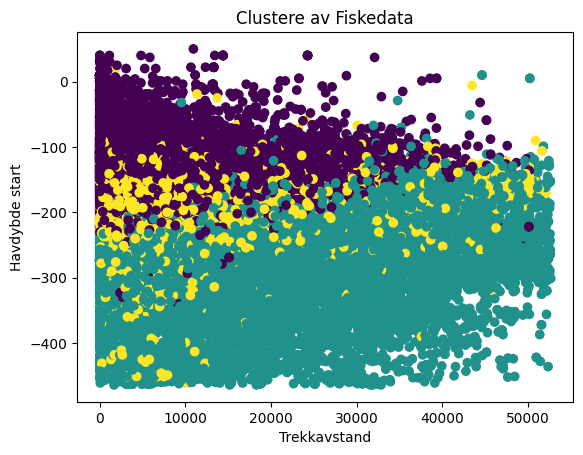

In [543]:
#3. Ser på sammenheng mellom trekkavstand og havdybde start
plt.scatter(clustering_data['Trekkavstand'], clustering_data['Havdybde start'], c=y_pred, cmap='viridis')
plt.xlabel('Trekkavstand')
plt.ylabel('Havdybde start')

plt.title('Clustere av Fiskedata')
plt.show()

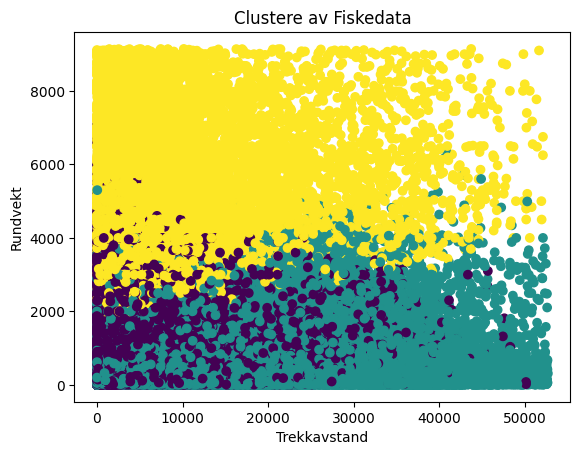

In [544]:
#4. Ser på sammenheng mellom trekkavstand og rundvekt
plt.scatter(clustering_data['Trekkavstand'], clustering_data['Rundvekt'], c=y_pred, cmap='viridis')
plt.xlabel('Trekkavstand')
plt.ylabel('Rundvekt')

plt.title('Clustere av Fiskedata')
plt.show()

**Resultater av clustering**

Basert på de ulike resultatene over, kan diagram 1 og 2 vise tydelige tendenser til clustering. (Havdybde start/stopp mot rundvekt). Basert på clusterne er det rimelig å anta at det er sei som har høyest rundvekt, dypvannsreke er nede til venstre og taskekrabbe øverst til venstre.


# 4: Diskusjon av resultater og konklusjon

Vi ønsket som utgangspunkt å predikere rundvekt ved seifiske ved bruk av trål i et bestemt område da vi startet på oppgaven. Vi bygget to maskinlæringsmodeller for klassifikasjon (KNN og Decision tree), en dyptlærende regresjonsmodell (MLP Regressor). I tillegg bygget vi en modell for clustering.

KNN endte på et resultat på 0.39, som sier oss at modellen til en viss grad fungerer, men den predikerer ikke med stor nøyaktighet. Decision tree ga oss resultat på 0.43, som betyr at den også predikerer med en del usikkerhet. MLP regressor endte imidlertid opp med et resultat på 0.73, noe vi vurderer som et relativt godt resultat. Videre gav modellen for clustering akseptable resultater, ved å gi oss tre tydelige klynger, selv om resultatene kan være noe usikre.

Oppsummert kan vi si at maskinlæringsmodellene vi har bygget ikke predikerer med stor nøyaktighet, med unntak av MLP regressor, som gav en relativt høy score. Dette kan ha flere årsaker. Det er mulig vi kunne gjort en mer omfattende preprosessering i forkant av byggingen av modellene. Det kan også være at modellene vi har valgt å bygge ikke har vært optimale for å predikere med utgangspunkt i det gitte datasettet, og at det dermed ikke har vært mulig å oppnå høyere resultater med valgte modeller. Ettersom fiske i utgangspunktet er et yrke hvor man opererer med stor grad av tilfeldigheter, kan det likevel være begrenset hvor presist en maskinlæringsmodell kan predikere rundvekt av fiske, uavhengig av valg av modell.

Gitt oppgavens omfang og tidsbegrensninger, anser vi oss fornøyde med resultatene vi har fått til nå. Vi ser likevel at det er rom for ytterligere forbedring av både preprosesseringen og de valgte modeller. Dette kunne vært interessante å utforske nærmere ved en senere anledning.

# 5: Referanser


Fiskeridirektoratet (2018). Havområder fra 2018. Https://open-data-fiskeridirektoratet-fiskeridir.hub.arcgis.com/datasets/1b8c3425aaf643e9b2abd3bc70111697/explore

Fiskeridirektoratet (2022). Redskapstyper. https://www.fiskeridir.no/Yrkesfiske/Tema/redskapshefte/Redskapshefte.pdf

Havforskningsinstituttet (2019) Tema: Sei i Nordsjøen, Skagerrak og vest av Skottland. https://www.hi.no/hi/temasider/arter/sei-i-nordsjoen

Havforskningsinstituttet (2019). Tema: Sei - Nordaustarktisk. https://www.hi.no/hi/temasider/arter/nordaustarktisk-sei

Muller, A. C & Guido, S (2017). Introduction to Machine Learning with Python: A guide for Data Scientists. O’Reilly Media.

Osnes, A. (2024) Bruttotonn. I Store Norske Leksikon https://snl.no/bruttotonn